# Zero inflated bionomial

## function: zeroinflatedbinomial (L-BFGS-B)

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import binom, norm
from scipy.special import expit, logit
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import time

class ZeroInflatedBinomial:
    """Zero-Inflated Binomial"""
    
    def __init__(self, n_trials=9):
        self.n_trials = n_trials
        self.fitted = False
        self.params = None
        self.se = None
        self.scaler = StandardScaler()
        
    def _loglik(self, params, y, X):
        """负对数似然函数"""
        n_obs, n_features = X.shape
        
        # 参数分解
        alpha_zi = params[0]
        beta_zi = params[1:n_features+1]
        alpha_bin = params[n_features+1]
        beta_bin = params[n_features+2:]
        
        # 线性预测器
        logit_psi = alpha_zi + X @ beta_zi
        logit_p = alpha_bin + X @ beta_bin
        
        # 转换为概率，避免数值问题
        psi = expit(np.clip(logit_psi, -20, 20))  # zero-inflation概率
        p = expit(np.clip(logit_p, -20, 20))      # binomial成功概率
        
        # Zero-inflated binomial likelihood
        ll = np.zeros(n_obs)
        
        # y=0的情况
        zero_mask = (y == 0)
        if np.any(zero_mask):
            prob_zero_zi = psi[zero_mask]  # 来自zero-inflation
            prob_zero_bin = (1 - psi[zero_mask]) * binom.pmf(0, self.n_trials, p[zero_mask])  # 来自binomial
            ll[zero_mask] = np.log(np.maximum(prob_zero_zi + prob_zero_bin, 1e-15))
        
        # y>0的情况  
        nonzero_mask = ~zero_mask
        if np.any(nonzero_mask):
            prob_nonzero = (1 - psi[nonzero_mask]) * binom.pmf(y[nonzero_mask], self.n_trials, p[nonzero_mask])
            ll[nonzero_mask] = np.log(np.maximum(prob_nonzero, 1e-15))
        
        return -np.sum(ll)  # 返回负对数似然
    
    def _gradient(self, params, y, X):
        """梯度函数（数值梯度）"""
        eps = 1e-6
        grad = np.zeros_like(params)
        f0 = self._loglik(params, y, X)
        
        for i in range(len(params)):
            params_plus = params.copy()
            params_plus[i] += eps
            grad[i] = (self._loglik(params_plus, y, X) - f0) / eps
            
        return grad
    
    def fit(self, X, y, standardize=True, method='L-BFGS-B', maxiter=1000):
        """拟合模型"""
        # 数据预处理
        X = np.asarray(X)
        y = np.asarray(y)
        
        if X.ndim == 1:
            X = X.reshape(-1, 1)
            
        if standardize:
            X = self.scaler.fit_transform(X)
        
        n_obs, n_features = X.shape
        
        # 初始参数估计
        # 使用简单的启发式方法
        zero_prop = np.mean(y == 0)
        mean_nonzero = np.mean(y[y > 0]) if np.any(y > 0) else 0.5
        
        # 初始值
        initial_psi = np.clip(zero_prop * 1.2, 0.01, 0.99)  # zero-inflation概率
        initial_p = np.clip(mean_nonzero / self.n_trials, 0.01, 0.99)  # binomial概率
        
        initial_params = np.concatenate([
            [logit(initial_psi)],  # alpha_zi
            np.zeros(n_features),  # beta_zi
            [logit(initial_p)],    # alpha_bin  
            np.zeros(n_features)   # beta_bin
        ])
        
        print(f"开始拟合模型... 样本数: {n_obs}, 特征数: {n_features}")
        print(f"零值比例: {zero_prop:.3f}")
        print(f"初始zero-inflation概率: {initial_psi:.3f}")
        print(f"初始binomial概率: {initial_p:.3f}")

        progress = tqdm(total=maxiter, desc="优化进度", position=0)
        def callback(xk):
            # 每次迭代调用一次
            progress.update(1)
        
        # 优化
        try:
            result = minimize(
                fun=self._loglik,
                x0=initial_params,
                args=(y, X),
                method=method,
                jac=self._gradient,
                options={'maxiter': maxiter, 'disp': True},
                callback=callback
            )
            progress.close()
            
            if not result.success:
                print(f"Warning: 优化可能未收敛. Message: {result.message}")
            
            self.params = result.x
            self.result = result
            
            # 计算标准误（使用Hessian矩阵）
            try:
                hessian = self._compute_hessian(X, y)
                self.se = np.sqrt(np.diag(np.linalg.inv(hessian)))
            except:
                print("Warning: 无法计算标准误")
                self.se = None
            
            self.fitted = True
            
            print(f"优化完成. 负对数似然: {result.fun:.4f}")
            print("scaler mean, scale:", self.scaler.mean_, self.scaler.scale_)
            return self
            
        except Exception as e:
            print(f"拟合失败: {e}")
            raise
        
    def _compute_hessian(self, X, y):
        """数值计算Hessian矩阵"""
        eps = 1e-6
        n_params = len(self.params)
        hessian = np.zeros((n_params, n_params))
        
        f0 = self._loglik(self.params, y, X)
        
        for i in range(n_params):
            for j in range(i, n_params):
                # 计算二阶偏导数
                params_ij = self.params.copy()
                params_ij[i] += eps
                params_ij[j] += eps
                f_ij = self._loglik(params_ij, y, X)
                
                params_i = self.params.copy()
                params_i[i] += eps
                f_i = self._loglik(params_i, y, X)
                
                params_j = self.params.copy()
                params_j[j] += eps
                f_j = self._loglik(params_j, y, X)
                
                hessian[i, j] = (f_ij - f_i - f_j + f0) / (eps * eps)
                hessian[j, i] = hessian[i, j]
        
        return hessian
    
    def predict_proba(self, X):
        """预测概率"""
        if not self.fitted:
            raise ValueError("模型未拟合")
        
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        
        X = self.scaler.transform(X)
        n_features = X.shape[1]
        
        # 提取参数
        alpha_zi = self.params[0]
        beta_zi = self.params[1:n_features+1]
        alpha_bin = self.params[n_features+1]
        beta_bin = self.params[n_features+2:]
        
        # 计算概率
        logit_psi = alpha_zi + X @ beta_zi
        logit_p = alpha_bin + X @ beta_bin
        
        psi = expit(logit_psi)  # zero-inflation概率
        p = expit(logit_p)      # binomial成功概率
        
        # 计算每个可能值的概率
        probs = np.zeros((len(X), self.n_trials + 1))
        
        for k in range(self.n_trials + 1):
            if k == 0:
                # P(Y=0) = psi + (1-psi) * P(Bin=0)
                probs[:, k] = psi + (1 - psi) * binom.pmf(0, self.n_trials, p)
            else:
                # P(Y=k) = (1-psi) * P(Bin=k)
                probs[:, k] = (1 - psi) * binom.pmf(k, self.n_trials, p)
        
        return probs, psi, p
    
    def predict(self, X):
        """预测期望值"""
        probs, psi, p = self.predict_proba(X)
        # 期望值 = (1-psi) * n * p
        return (1 - psi) * self.n_trials * p
    
    def summary(self):
        """模型摘要"""
        if not self.fitted:
            raise ValueError("模型未拟合")
        
        n_features = (len(self.params) - 2) // 2
        
        print("Zero-Inflated Binomial回归结果")
        print("=" * 50)
        print(f"观测数: {len(self.params)//2}")  # 近似
        print(f"负对数似然: {self.result.fun:.4f}")
        print(f"AIC: {2 * len(self.params) + 2 * self.result.fun:.4f}")
        print()
        
        # Zero-inflation部分
        print("Zero-inflation部分 (logit):")
        print("-" * 30)
        print(f"{'参数':<15} {'估计值':<10} {'标准误':<10} {'Z值':<10} {'P值':<10}")
        
        alpha_zi = self.params[0]
        if self.se is not None:
            se_alpha_zi = self.se[0]
            z_alpha_zi = alpha_zi / se_alpha_zi
            p_alpha_zi = 2 * (1 - norm.cdf(abs(z_alpha_zi)))
            print(f"{'Intercept':<15} {alpha_zi:<10.4f} {se_alpha_zi:<10.4f} {z_alpha_zi:<10.4f} {p_alpha_zi:<10.4f}")
        else:
            print(f"{'Intercept':<15} {alpha_zi:<10.4f} {'N/A':<10} {'N/A':<10} {'N/A':<10}")
        
        for i in range(n_features):
            beta_zi = self.params[1 + i]
            param_name = f"X{i+1}" if n_features > 1 else "X"
            if self.se is not None:
                se_beta_zi = self.se[1 + i]
                z_beta_zi = beta_zi / se_beta_zi
                p_beta_zi = 2 * (1 - norm.cdf(abs(z_beta_zi)))
                print(f"{param_name:<15} {beta_zi:<10.4f} {se_beta_zi:<10.4f} {z_beta_zi:<10.4f} {p_beta_zi:<10.4f}")
            else:
                print(f"{param_name:<15} {beta_zi:<10.4f} {'N/A':<10} {'N/A':<10} {'N/A':<10}")
        
        print()
        # Binomial部分
        print("Binomial部分 (logit):")
        print("-" * 30)
        print(f"{'参数':<15} {'估计值':<10} {'标准误':<10} {'Z值':<10} {'P值':<10}")
        
        alpha_bin = self.params[n_features + 1]
        if self.se is not None:
            se_alpha_bin = self.se[n_features + 1]
            z_alpha_bin = alpha_bin / se_alpha_bin
            p_alpha_bin = 2 * (1 - norm.cdf(abs(z_alpha_bin)))
            print(f"{'Intercept':<15} {alpha_bin:<10.4f} {se_alpha_bin:<10.4f} {z_alpha_bin:<10.4f} {p_alpha_bin:<10.4f}")
        else:
            print(f"{'Intercept':<15} {alpha_bin:<10.4f} {'N/A':<10} {'N/A':<10} {'N/A':<10}")
        
        for i in range(n_features):
            beta_bin = self.params[n_features + 2 + i]
            param_name = f"X{i+1}" if n_features > 1 else "X"
            if self.se is not None:
                se_beta_bin = self.se[n_features + 2 + i]
                z_beta_bin = beta_bin / se_beta_bin
                p_beta_bin = 2 * (1 - norm.cdf(abs(z_beta_bin)))
                print(f"{param_name:<15} {beta_bin:<10.4f} {se_beta_bin:<10.4f} {z_beta_bin:<10.4f} {p_beta_bin:<10.4f}")
            else:
                print(f"{param_name:<15} {beta_bin:<10.4f} {'N/A':<10} {'N/A':<10} {'N/A':<10}")
    
    def plot_fit(self, X, y, feature_name="Remoteness", sample_size=5000):
        """Plot ZIB model results with non-structural-zero expectation in English"""
        if not self.fitted:
            raise ValueError("Model is not fitted yet")
        
        X = np.asarray(X).flatten()
        y = np.asarray(y)
        
        # 抽样绘图，提升速度
        if len(X) > sample_size:
            idx = np.random.choice(len(X), size=sample_size, replace=False)
            X_plot = X[idx]
            y_plot = y[idx]
        else:
            X_plot = X
            y_plot = y
        
        # 创建预测网格
        x_range = np.linspace(X.min(), X.max(), 100)
        probs, psi, p = self.predict_proba(x_range.reshape(-1, 1))
        # 蓝线改为非结构性零格子期望建筑数
        pred_mean_nonstructural = self.n_trials * p
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # 观测数据分布
        axes[0, 0].hist(y_plot, bins=range(self.n_trials + 2), alpha=0.7, density=True, edgecolor='black')
        axes[0, 0].set_title('Observed Building Count Distribution')
        axes[0, 0].set_xlabel('Number of Buildings per Cell')
        axes[0, 0].set_ylabel('Density')
        
        # Zero-inflation probability
        axes[0, 1].scatter(X_plot, y_plot == 0, alpha=0.3, s=1)
        axes[0, 1].plot(x_range, psi, 'r-', linewidth=2, label='Predicted Zero-Inflation Probability')
        axes[0, 1].set_title('Zero-Inflation Probability')
        axes[0, 1].set_xlabel(feature_name)
        axes[0, 1].set_ylabel('P(Y=0 | structural zero)')
        axes[0, 1].legend()
        
        # Binomial success probability
        nonzero_mask = y_plot > 0
        if np.any(nonzero_mask):
            axes[1, 0].scatter(X_plot[nonzero_mask], y_plot[nonzero_mask]/self.n_trials, alpha=0.3, s=1)
        axes[1, 0].plot(x_range, p, 'g-', linewidth=2, label='Predicted Binomial Success Probability')
        axes[1, 0].set_title('Binomial Success Probability (Non-Structural Zero Cells)')
        axes[1, 0].set_xlabel(feature_name)
        axes[1, 0].set_ylabel('Success Probability per Trial')
        axes[1, 0].legend()
        
        # Non-structural zero expected building count
        axes[1, 1].scatter(X_plot, y_plot, alpha=0.3, s=1)
        axes[1, 1].plot(x_range, pred_mean_nonstructural, 'b-', linewidth=2, label='Expected Building Count (Non-Structural Zero Cells)')
        axes[1, 1].set_title('Expected Building Count per Non-Structural Zero Cell')
        axes[1, 1].set_xlabel(feature_name)
        axes[1, 1].set_ylabel('Expected Buildings')
        axes[1, 1].legend()
        
        plt.tight_layout()
        plt.show()

## Read csv of 3 case cities

In [7]:
# Antananarivo
df_16 = pd.read_csv("aggregated_data/Antananarivo_2016_3x3_windows.csv")
cities = pd.read_csv("CitiesDB_new.csv")
pop_16 = cities.loc[cities['Name'] == 'Antananarivo', 'pop_2016_UN'].iloc[0] * 1000
df_16['remoteness'] = (df_16['distance_to_center'] / np.sqrt(pop_16)) * 1000
df_16['bd'] = 9

In [8]:
# Antananarivo Sample 10k
df_16_sample = pd.read_csv("df_sample_16_Anta_10k.csv")
cities = pd.read_csv("CitiesDB_new.csv")
pop_16 = cities.loc[cities['Name'] == 'Antananarivo', 'pop_2016_UN'].iloc[0] * 1000
df_16_sample['remoteness'] = (df_16_sample['distance_to_center'] / np.sqrt(pop_16)) * 1000
df_16_sample['bd'] = 9

In [9]:
# Mumbai
df_16_mumbai = pd.read_csv("aggregated_data/Mumbai_2016_3x3_windows.csv")
cities = pd.read_csv("CitiesDB_new.csv")
pop_16 = cities.loc[cities['Name'] == 'Mumbai', 'pop_2016_UN'].iloc[0] * 1000
df_16_mumbai['remoteness'] = (df_16_mumbai['distance_to_center'] / np.sqrt(pop_16)) * 1000
df_16_mumbai['bd'] = 9

In [10]:
# Mexico City
df_16_mexico = pd.read_csv("aggregated_data/Mexico City_2016_3x3_windows.csv")
cities = pd.read_csv("CitiesDB_new.csv")
pop_16 = cities.loc[cities['Name'] == 'Mexico City', 'pop_2016_UN'].iloc[0] * 1000
df_16_mexico['remoteness'] = (df_16_mexico['distance_to_center'] / np.sqrt(pop_16)) * 1000
df_16_mexico['bd'] = 9

## test ZIB on 3 case cities

### Antananarivo Sample

In [4]:
import time
from tqdm import tqdm

model_sample = ZeroInflatedBinomial(n_trials=9)

start = time.time()
result_all_sample = model_sample.fit(df_16_sample[['remoteness']], df_16_sample['building_count'], maxiter=200)
end = time.time()

print(f"总耗时: {end - start:.2f} 秒")

params_orig = unscale_params(model_sample)
print("Unscaled params (alpha_zi, beta_zi, alpha_bin, beta_bin):", params_orig)

开始拟合模型... 样本数: 100000, 特征数: 1
零值比例: 0.927
初始zero-inflation概率: 0.990
初始binomial概率: 0.246


优化进度:   6%|█▉                              | 12/200 [00:00<00:10, 18.17it/s]


优化完成. 负对数似然: 32210.8088
scaler mean, scale: [8.95707856] [3.33724346]
总耗时: 0.91 秒
Unscaled params (alpha_zi, beta_zi, alpha_bin, beta_bin): [-0.42666343  0.38376954 -0.66567337 -0.13555972]


### Antananarivo

In [8]:
import time
from tqdm import tqdm

model = ZeroInflatedBinomial(n_trials=9)

start = time.time()
result_all = model.fit(df_16[['remoteness']], df_16['building_count'], maxiter=200)
end = time.time()

print(f"总耗时: {end - start:.2f} 秒")

开始拟合模型... 样本数: 15992001, 特征数: 1
零值比例: 0.928
初始zero-inflation概率: 0.990
初始binomial概率: 0.247


优化进度:   6%|█▉                              | 12/200 [01:54<29:53,  9.54s/it]


优化完成. 负对数似然: 5102888.0905
scaler mean, scale: [8.95732042] [3.33862208]
总耗时: 157.43 秒


In [13]:
# params = result_all.params
# print(params)
# params_sample = result_all_sample.params
# print(params_sample)

In [11]:
mu = 8.95707856
sigma = 3.33724346
alpha_zi_std = params[0]; beta_zi_std = params[1]
alpha_bin_std = params[2]; beta_bin_std = params[3]

beta_zi_orig = beta_zi_std / sigma
alpha_zi_orig = alpha_zi_std - beta_zi_std * mu / sigma

beta_bin_orig = beta_bin_std / sigma
alpha_bin_orig = alpha_bin_std - beta_bin_std * mu / sigma

print("psi (orig scale):", alpha_zi_orig, beta_zi_orig)
print("pi  (orig scale):", alpha_bin_orig, beta_bin_orig)

psi (orig scale): -0.4413851936249906 0.3876413840465406
pi  (orig scale): -0.6662483859140713 -0.13598504176821585


Negative log-likelihood: 5102888.090500672
Observed zero proportion: 0.9276164377428441
Predicted zero proportion: 0.927618319035304
MSE: 0.4127615693954929 MAE: 0.23918049042040146


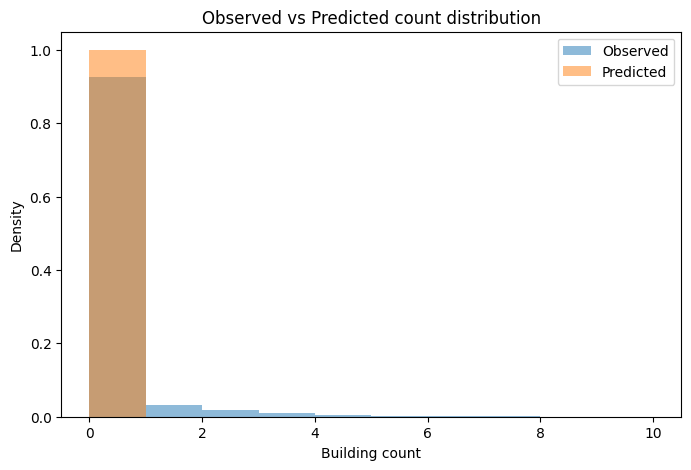

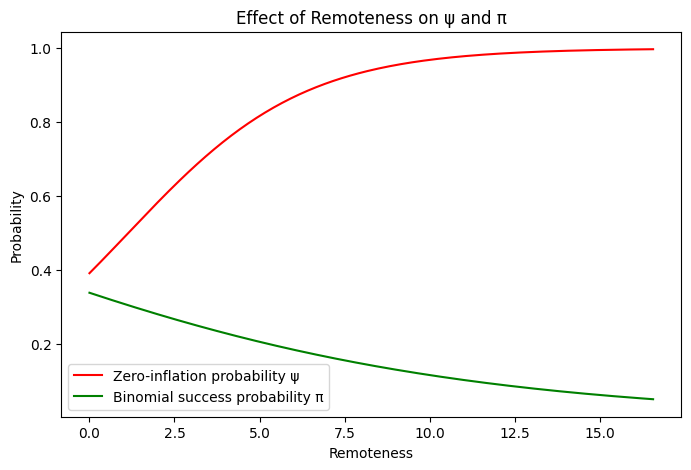

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# 提取样本
X_all = df_16[['remoteness']].values
y_all = df_16['building_count'].values

# Log-likelihood
neg_loglik = model.result.fun
print("Negative log-likelihood:", neg_loglik)

# 预测零比例 vs 实际零比例
probs_all, psi_all, p_all = model.predict_proba(X_all)
pred_zero_prob = np.mean(probs_all[:, 0])
obs_zero_prob = np.mean(y_all == 0)
print("Observed zero proportion:", obs_zero_prob)
print("Predicted zero proportion:", pred_zero_prob)

# 预测期望值 & MSE/MAE
y_pred = model.predict(X_all)
mse = np.mean((y_all - y_pred)**2)
mae = np.mean(np.abs(y_all - y_pred))
print("MSE:", mse, "MAE:", mae)

# 直方图对比
plt.figure(figsize=(8,5))
plt.hist(y_all, bins=range(model.n_trials+2), alpha=0.5, label='Observed', density=True)
plt.hist(np.argmax(probs_all, axis=1), bins=range(model.n_trials+2), alpha=0.5, label='Predicted', density=True)
plt.xlabel("Building count")
plt.ylabel("Density")
plt.legend()
plt.title("Observed vs Predicted count distribution")
plt.show()

# Remoteness 对 ψ 和 π 的影响
x_grid = np.linspace(X_all.min(), X_all.max(), 200).reshape(-1,1)
probs_grid, psi_grid, p_grid = model.predict_proba(x_grid)

plt.figure(figsize=(8,5))
plt.plot(x_grid, psi_grid, label='Zero-inflation probability ψ', color='red')
plt.plot(x_grid, p_grid, label='Binomial success probability π', color='green')
plt.xlabel("Remoteness")
plt.ylabel("Probability")
plt.legend()
plt.title("Effect of Remoteness on ψ and π")
plt.show()

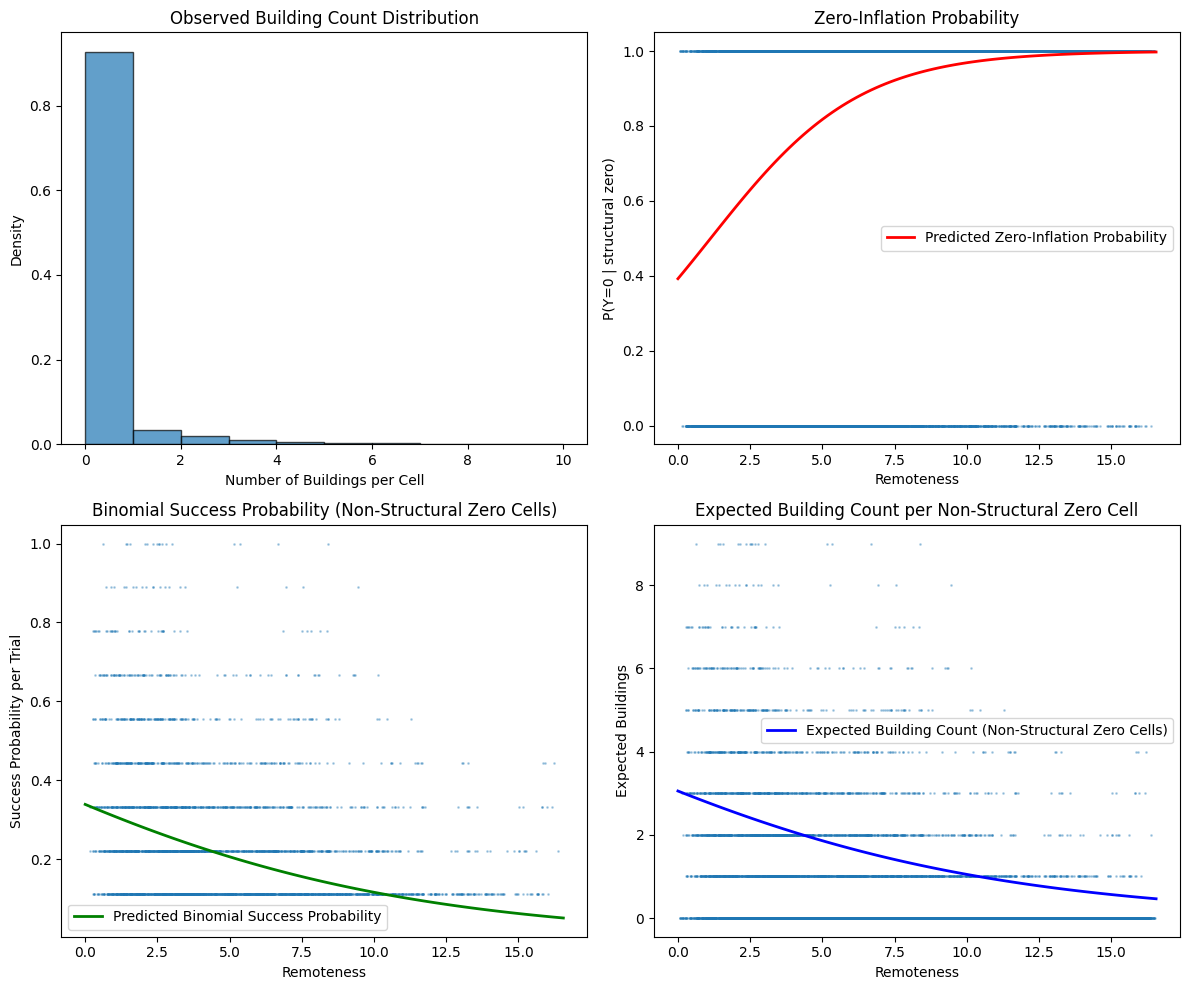

In [5]:
model.plot_fit(df_16['remoteness'], df_16['building_count'], 'Remoteness',sample_size=50000)

### Mumbai

In [31]:
print(max(df_16_mumbai['remoteness']))
print(max(df_16['remoteness']))

6.219726158957382
16.555315441362353


In [14]:
import time
from tqdm import tqdm

model2 = ZeroInflatedBinomial(n_trials=9)

start = time.time()
result2 = model2.fit(df_16_mumbai[['remoteness']], df_16_mumbai['building_count'], maxiter=200)
end = time.time()

print(f"总耗时: {end - start:.2f} 秒")

开始拟合模型... 样本数: 15996000, 特征数: 1
零值比例: 0.917
初始zero-inflation概率: 0.990
初始binomial概率: 0.387


优化进度:   5%|█▌                              | 10/200 [01:47<33:58, 10.73s/it]


优化完成. 负对数似然: 7615036.5686
scaler mean, scale: [3.36518499] [1.25432244]
总耗时: 150.30 秒


In [16]:
params_orig = unscale_params(model2)
print("Unscaled params (alpha_zi, beta_zi, alpha_bin, beta_bin):", params_orig)

Unscaled params (alpha_zi, beta_zi, alpha_bin, beta_bin): [ 1.2354991   0.3705028  -0.42621956 -0.02023301]


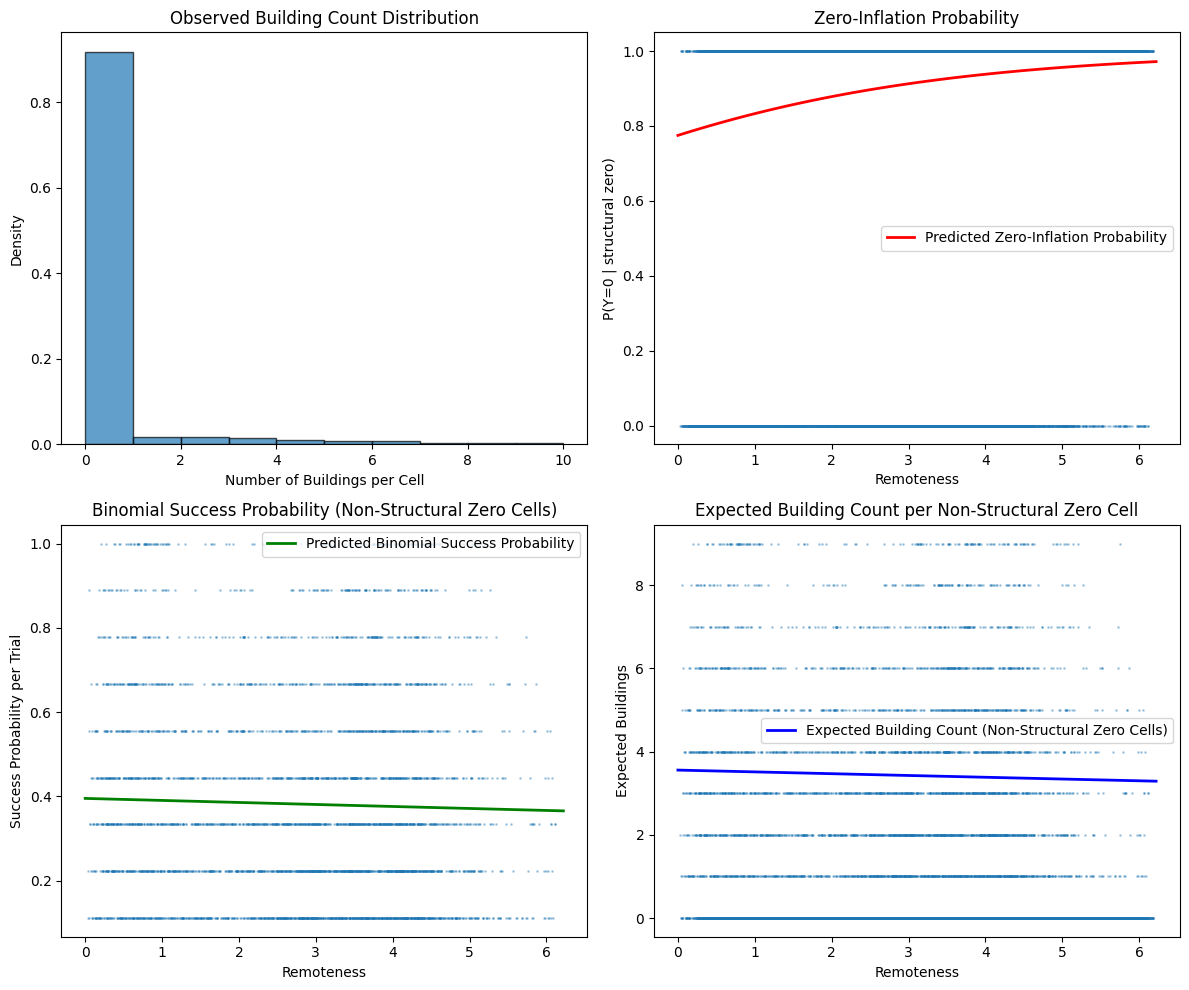

In [23]:
model2.plot_fit(df_16_mumbai['remoteness'], df_16_mumbai['building_count'], 'Remoteness',sample_size=50000)

In [24]:
print(result2.params)

[ 2.4823097   0.46473082 -0.49430747 -0.02537826]


Negative log-likelihood: 7615036.568606862
Observed zero proportion: 0.9172771317829458
Predicted zero proportion: 0.9172792952655239
MSE: 1.304752081818466 MAE: 0.516951802211399


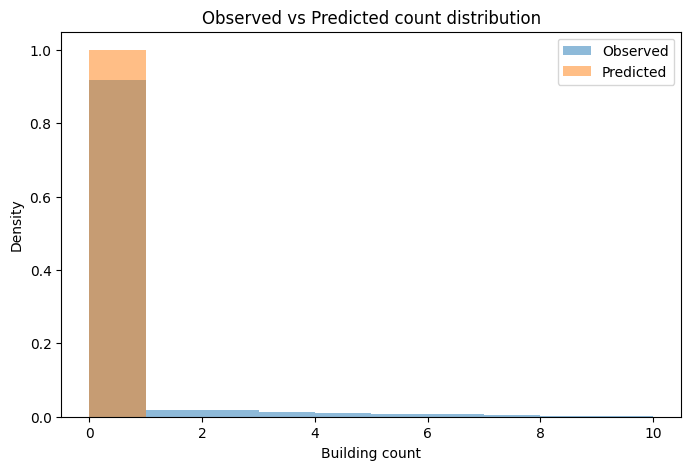

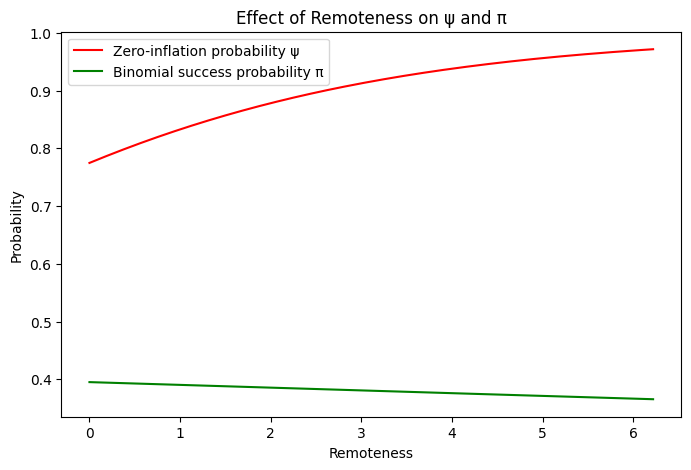

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# 提取样本
X_all = df_16_mumbai[['remoteness']].values
y_all = df_16_mumbai['building_count'].values

# Log-likelihood
neg_loglik = model2.result.fun
print("Negative log-likelihood:", neg_loglik)

# 预测零比例 vs 实际零比例
probs_all, psi_all, p_all = model2.predict_proba(X_all)
pred_zero_prob = np.mean(probs_all[:, 0])
obs_zero_prob = np.mean(y_all == 0)
print("Observed zero proportion:", obs_zero_prob)
print("Predicted zero proportion:", pred_zero_prob)

# 预测期望值 & MSE/MAE
y_pred = model2.predict(X_all)
mse = np.mean((y_all - y_pred)**2)
mae = np.mean(np.abs(y_all - y_pred))
print("MSE:", mse, "MAE:", mae)

# 直方图对比
plt.figure(figsize=(8,5))
plt.hist(y_all, bins=range(model2.n_trials+2), alpha=0.5, label='Observed', density=True)
plt.hist(np.argmax(probs_all, axis=1), bins=range(model2.n_trials+2), alpha=0.5, label='Predicted', density=True)
plt.xlabel("Building count")
plt.ylabel("Density")
plt.legend()
plt.title("Observed vs Predicted count distribution")
plt.show()

# Remoteness 对 ψ 和 π 的影响
x_grid = np.linspace(X_all.min(), X_all.max(), 200).reshape(-1,1)
probs_grid, psi_grid, p_grid = model2.predict_proba(x_grid)

plt.figure(figsize=(8,5))
plt.plot(x_grid, psi_grid, label='Zero-inflation probability ψ', color='red')
plt.plot(x_grid, p_grid, label='Binomial success probability π', color='green')
plt.xlabel("Remoteness")
plt.ylabel("Probability")
plt.legend()
plt.title("Effect of Remoteness on ψ and π")
plt.show()

### Mexico City

In [18]:
import time
from tqdm import tqdm

model3 = ZeroInflatedBinomial(n_trials=9)

start = time.time()
result3 = model3.fit(df_16_mexico[['remoteness']], df_16_mexico['building_count'], maxiter=200)
end = time.time()

print(f"总耗时: {end - start:.2f} 秒")

开始拟合模型... 样本数: 15996000, 特征数: 1
零值比例: 0.476
初始zero-inflation概率: 0.571
初始binomial概率: 0.435


优化进度:   4%|█▍                               | 9/200 [01:40<35:39, 11.20s/it]


优化完成. 负对数似然: 30141505.7256
scaler mean, scale: [3.20936438] [1.19639818]
总耗时: 148.80 秒


In [20]:
params_orig = unscale_params(model3)
print("Unscaled params (alpha_zi, beta_zi, alpha_bin, beta_bin):", params_orig)

Unscaled params (alpha_zi, beta_zi, alpha_bin, beta_bin): [-1.84094514  0.53334158  0.21447513 -0.17171822]


Negative log-likelihood: 30141505.725591343
Observed zero proportion: 0.47609939984996247
Predicted zero proportion: 0.4761015865798281
MSE: 5.729514686387056 MAE: 1.966124239784908


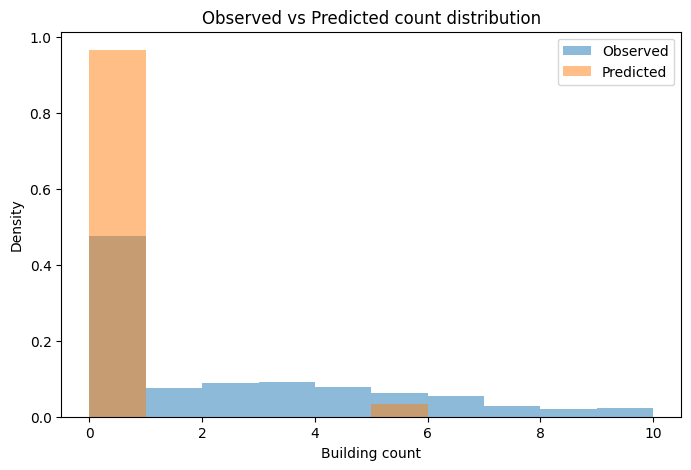

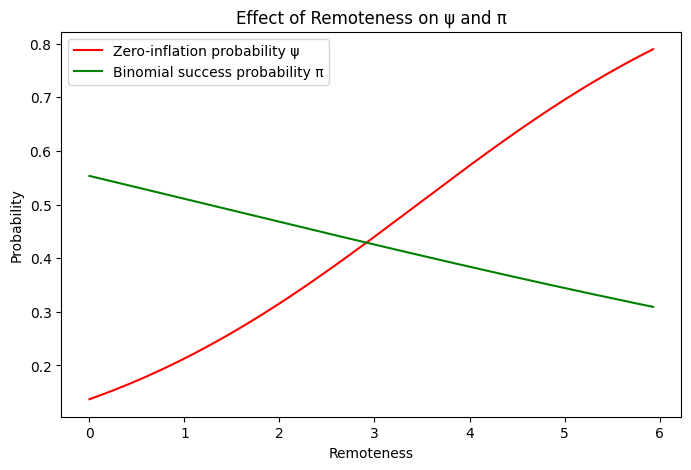

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# 提取样本
X_all = df_16_mexico[['remoteness']].values
y_all = df_16_mexico['building_count'].values

# Log-likelihood
neg_loglik = model3.result.fun
print("Negative log-likelihood:", neg_loglik)

# 预测零比例 vs 实际零比例
probs_all, psi_all, p_all = model3.predict_proba(X_all)
pred_zero_prob = np.mean(probs_all[:, 0])
obs_zero_prob = np.mean(y_all == 0)
print("Observed zero proportion:", obs_zero_prob)
print("Predicted zero proportion:", pred_zero_prob)

# 预测期望值 & MSE/MAE
y_pred = model3.predict(X_all)
mse = np.mean((y_all - y_pred)**2)
mae = np.mean(np.abs(y_all - y_pred))
print("MSE:", mse, "MAE:", mae)

# 直方图对比
plt.figure(figsize=(8,5))
plt.hist(y_all, bins=range(model3.n_trials+2), alpha=0.5, label='Observed', density=True)
plt.hist(np.argmax(probs_all, axis=1), bins=range(model3.n_trials+2), alpha=0.5, label='Predicted', density=True)
plt.xlabel("Building count")
plt.ylabel("Density")
plt.legend()
plt.title("Observed vs Predicted count distribution")
plt.show()

# Remoteness 对 ψ 和 π 的影响
x_grid = np.linspace(X_all.min(), X_all.max(), 200).reshape(-1,1)
probs_grid, psi_grid, p_grid = model3.predict_proba(x_grid)

plt.figure(figsize=(8,5))
plt.plot(x_grid, psi_grid, label='Zero-inflation probability ψ', color='red')
plt.plot(x_grid, p_grid, label='Binomial success probability π', color='green')
plt.xlabel("Remoteness")
plt.ylabel("Probability")
plt.legend()
plt.title("Effect of Remoteness on ψ and π")
plt.show()

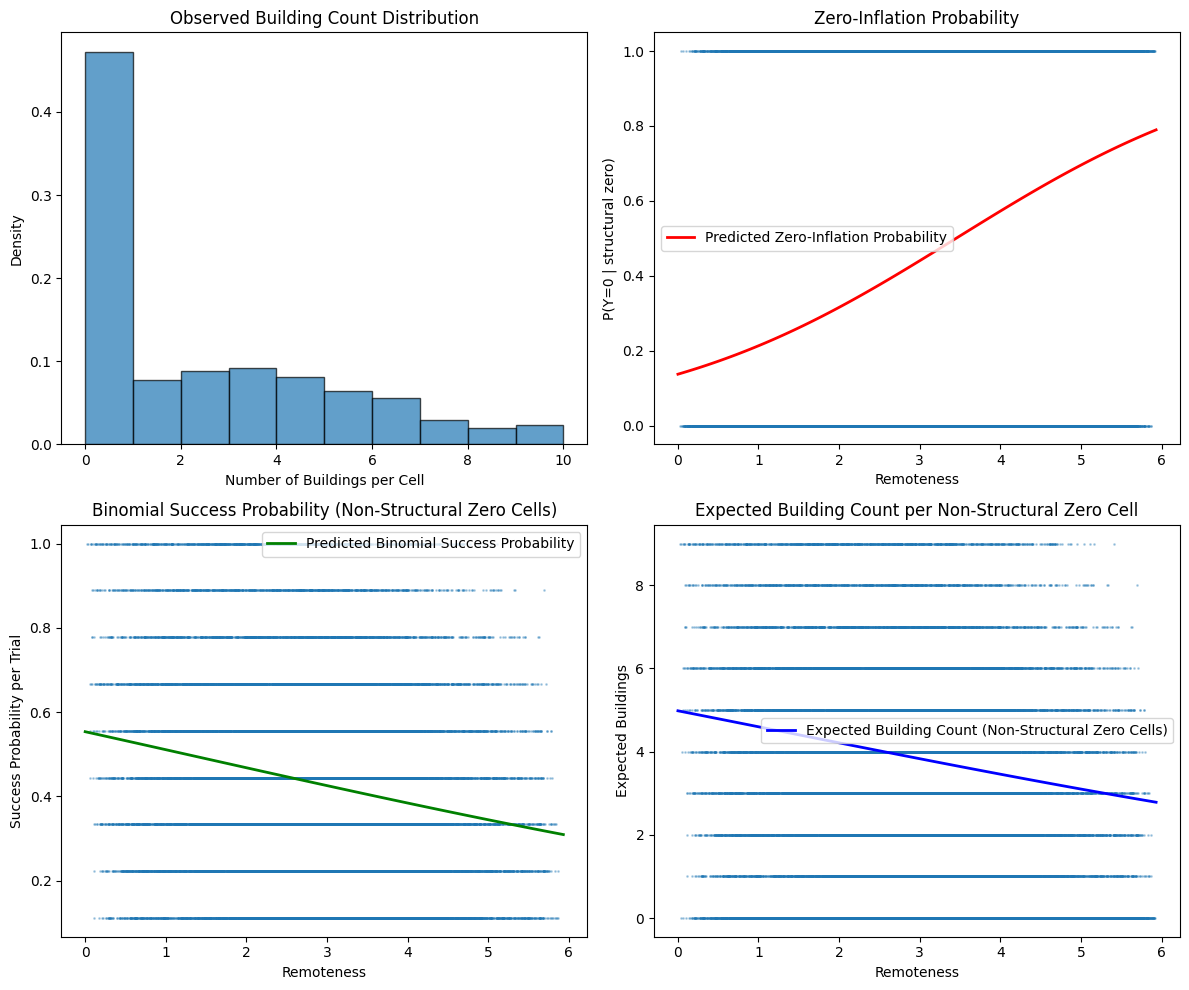

In [34]:
model3.plot_fit(df_16_mexico['remoteness'], df_16_mexico['building_count'], 'Remoteness',sample_size=50000)

## 比较不同package的优化结果

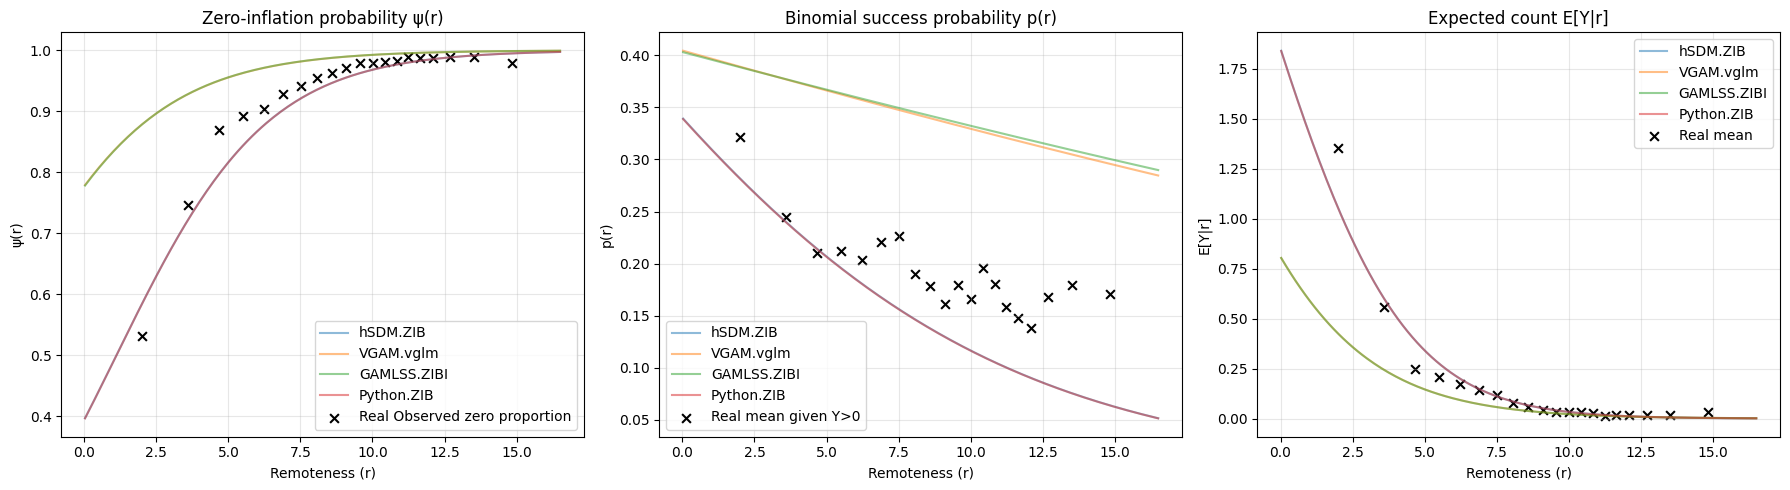

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit

# ---------- 观测数据的分箱统计 ----------
def empirical_points(df, n_bins=20):
    df = df.copy()
    df["bin"] = pd.qcut(df["remoteness"], n_bins, duplicates="drop")
    grouped = df.groupby("bin")

    r_mid = grouped["remoteness"].mean()
    zero_prob = grouped["building_count"].apply(lambda x: np.mean(x == 0))
    nonzero_mean = grouped["building_count"].apply(lambda x: x[x>0].mean()/9 if np.any(x>0) else np.nan)
    overall_mean = grouped["building_count"].mean()

    return r_mid, zero_prob, nonzero_mean, overall_mean

r_mid, zero_prob, nonzero_mean, overall_mean = empirical_points(df_16_sample, n_bins=20)

# ---------- 参数字典 ----------
params = {
    "hSDM.ZIB":   {"alpha_zi": -0.426, "beta_zi":  0.384,  "alpha_bin": -0.664, "beta_bin": -0.136},
    "VGAM.vglm":  {"alpha_zi":  1.253, "beta_zi":  0.363,  "alpha_bin": -0.387, "beta_bin": -0.0324},
    "GAMLSS.ZIBI":{"alpha_zi":  1.248, "beta_zi":  0.365,  "alpha_bin": -0.393, "beta_bin": -0.0305},
    "Python.ZIB": {"alpha_zi": -0.427, "beta_zi":  0.384,  "alpha_bin": -0.666, "beta_bin": -0.136}
}

n_trials = 9
r = np.linspace(df_16_sample["remoteness"].min(), df_16_sample["remoteness"].max(), 200)

# ---------- 画图 ----------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for method, par in params.items():
    psi = expit(par["alpha_zi"] + par["beta_zi"] * r)
    p   = expit(par["alpha_bin"] + par["beta_bin"] * r)
    expected = (1 - psi) * n_trials * p
    
    axes[0].plot(r, psi, label=method,alpha=0.5)
    axes[1].plot(r, p, label=method,alpha=0.5)
    axes[2].plot(r, expected, label=method,alpha=0.5)

# 加入观测点
axes[0].scatter(r_mid, zero_prob, c="black", s=40, marker="x", label="Real Observed zero proportion")
axes[1].scatter(r_mid, nonzero_mean, c="black", s=40, marker="x", label="Real mean given Y>0")
axes[2].scatter(r_mid, overall_mean, c="black", s=40, marker="x", label="Real mean")

# 设置标题和图例
axes[0].set_title("Zero-inflation probability ψ(r)")
axes[0].set_xlabel("Remoteness (r)")
axes[0].set_ylabel("ψ(r)")

axes[1].set_title("Binomial success probability p(r)")
axes[1].set_xlabel("Remoteness (r)")
axes[1].set_ylabel("p(r)")

axes[2].set_title("Expected count E[Y|r]")
axes[2].set_xlabel("Remoteness (r)")
axes[2].set_ylabel("E[Y|r]")

for ax in axes:
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 批量处理

In [3]:
import pandas as pd
import numpy as np
import time
import os
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.special import expit
import warnings
warnings.filterwarnings('ignore')

def unscale_params(model):
    """
    将标准化后的参数转换回原始尺度
    
    标准化模型: logit(psi) = alpha_zi_std + beta_zi_std * X_std
    其中 X_std = (X - mean) / std
    
    原始尺度: logit(psi) = alpha_zi + beta_zi * X
    
    关系:
    beta_zi = beta_zi_std / std
    alpha_zi = alpha_zi_std - beta_zi_std * mean / std
    """
    params_std = model.params
    remoteness_mean = model.scaler.mean_[0]
    remoteness_std = model.scaler.scale_[0]
    
    # 标准化参数
    alpha_zi_std = params_std[0]
    beta_zi_std = params_std[1]
    alpha_bin_std = params_std[2]
    beta_bin_std = params_std[3]
    
    # 转换到原始尺度
    beta_zi = beta_zi_std / remoteness_std
    alpha_zi = alpha_zi_std - beta_zi_std * remoteness_mean / remoteness_std
    
    beta_bin = beta_bin_std / remoteness_std
    alpha_bin = alpha_bin_std - beta_bin_std * remoteness_mean / remoteness_std
    
    return alpha_zi, beta_zi, alpha_bin, beta_bin


def fit_zib_cities(city_list, years=[2016, 2023], folder='aggregated_data', 
                   maxiter=1000, method='L-BFGS-B', save_diagnostics=True,
                   output_file='zib_fitting_results.csv', resume=True):
    """
    批量拟合多个城市多个年份的Zero-Inflated Binomial模型
    
    参数:
    ------
    city_list : list
        城市名称列表
    years : list
        年份列表
    folder : str
        数据文件夹路径
    maxiter : int
        最大迭代次数
    method : str
        优化方法 ('L-BFGS-B', 'BFGS', 'Newton-CG')
    save_diagnostics : bool
        是否保存详细诊断信息
    output_file : str
        输出CSV文件名（增量保存）
    resume : bool
        是否从上次中断处继续（跳过已完成的城市-年份）
        
    返回:
    ------
    df_results : DataFrame
        包含所有拟合结果的数据框
    diagnostics : dict (optional)
        详细诊断信息字典
    """
    results = []
    diagnostics = {}
    
    # 检查是否存在已有结果（断点续传）
    completed_set = set()
    if resume and os.path.exists(output_file):
        try:
            existing_results = pd.read_csv(output_file)
            completed_set = set(zip(existing_results['city'], existing_results['year']))
            results = existing_results.to_dict('records')
            print(f"📂 发现已有结果文件: {output_file}")
            print(f"✓ 已完成 {len(completed_set)} 个任务，将继续未完成的任务")
            print("=" * 80)
        except Exception as e:
            print(f"⚠️  读取已有结果失败: {e}")
            print("将从头开始拟合")
            completed_set = set()
    
    # 读取城市数据库
    try:
        cities = pd.read_csv("CitiesDB_new.csv")
    except FileNotFoundError:
        print("错误: CitiesDB_new.csv 文件未找到")
        return None
    
    print(f"开始批量拟合 {len(city_list)} 个城市，{len(years)} 个年份")
    print(f"优化方法: {method}, 最大迭代次数: {maxiter}")
    print("=" * 80)
    
    # 使用tqdm显示总进度
    total_tasks = len(city_list) * len(years)
    pbar = tqdm(total=total_tasks, desc="总进度")
    
    for year in years:
        for city in city_list:
            # 检查是否已完成
            if (city, year) in completed_set:
                print(f"⏭️  跳过已完成: {city} {year}")
                pbar.update(1)
                continue
            
            city_year_key = f"{city}_{year}"
            file_path = f"{folder}/{city}_{year}_3x3_windows.csv"
            
            try:
                # 读取数据
                df = pd.read_csv(file_path)
                n_obs = len(df)
                
                # 获取人口
                pop_col = f'pop_{year}_UN'
                if pop_col not in cities.columns:
                    print(f"\n⚠️  {city} {year}: 人口列 {pop_col} 不存在，跳过")
                    pbar.update(1)
                    continue
                
                pop = cities.loc[cities['Name'] == city, pop_col].iloc[0] * 1000
                
                # 计算 remoteness
                df['remoteness'] = (df['distance_to_center'] / np.sqrt(pop)) * 1000
                df['bd'] = 9
                
                # 数据摘要统计
                zero_ratio = (df['building_count'] == 0).mean()
                mean_nonzero = df.loc[df['building_count'] > 0, 'building_count'].mean() if (df['building_count'] > 0).any() else 0
                remoteness_mean = df['remoteness'].mean()
                remoteness_std = df['remoteness'].std()
                remoteness_min = df['remoteness'].min()
                remoteness_max = df['remoteness'].max()
                
                # 拟合模型
                model = ZeroInflatedBinomial(n_trials=9)
                start = time.time()
                
                try:
                    model.fit(
                        df[['remoteness']], 
                        df['building_count'], 
                        method=method,
                        maxiter=maxiter
                    )
                    
                    # 从model.result获取优化结果
                    result = model.result
                    fit_success = result.success
                    fit_message = result.message
                    n_iterations = result.nit
                    
                except Exception as e:
                    print(f"\n❌ {city} {year}: 拟合失败 - {str(e)}")
                    pbar.update(1)
                    continue
                
                end = time.time()
                fit_time = end - start
                
                # Unscale 参数到原始尺度
                alpha_zi, beta_zi, alpha_bin, beta_bin = unscale_params(model)
                
                # 计算中心点（remoteness=0）的概率
                psi_center = expit(alpha_zi)      # zero-inflation概率在中心
                pi_center = expit(alpha_bin)      # binomial成功概率在中心
                
                # 计算平均remoteness处的概率（更有实际意义）
                psi_mean = expit(alpha_zi + beta_zi * remoteness_mean)
                pi_mean = expit(alpha_bin + beta_bin * remoteness_mean)
                
                # 模型拟合统计量
                loglik = -result.fun
                k = 4  # 参数个数
                n = len(df)
                aic = 2 * k - 2 * loglik
                bic = k * np.log(n) - 2 * loglik
                
                # 预测与残差
                preds = model.predict(df[['remoteness']])
                residuals = df['building_count'] - preds
                mse = mean_squared_error(df['building_count'], preds)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(df['building_count'], preds)
                
                # 预测零值比例
                pred_probs, pred_psi, pred_pi = model.predict_proba(df[['remoteness']])
                pred_zero_ratio = pred_probs[:, 0].mean()
                
                # 伪R方 (McFadden's R-squared)
                # 零模型: 只有截距
                null_loglik = n * zero_ratio * np.log(zero_ratio + 1e-10) + \
                             n * (1 - zero_ratio) * np.log(1 - zero_ratio + 1e-10)
                pseudo_r2 = 1 - (loglik / null_loglik) if null_loglik != 0 else np.nan
                
                # 收集结果
                result_dict = {
                    'city': city,
                    'year': year,
                    'n_obs': n_obs,
                    'population': pop,
                    
                    # 原始尺度参数
                    'alpha_zi': alpha_zi,
                    'beta_zi': beta_zi,
                    'alpha_bin': alpha_bin,
                    'beta_bin': beta_bin,
                    
                    # 中心点概率（remoteness=0）
                    'psi_at_center': psi_center,
                    'pi_at_center': pi_center,
                    
                    # 平均remoteness处的概率（更有意义）
                    'psi_at_mean': psi_mean,
                    'pi_at_mean': pi_mean,
                    
                    # 数据统计
                    'zero_ratio_obs': zero_ratio,
                    'zero_ratio_pred': pred_zero_ratio,
                    'mean_nonzero_count': mean_nonzero,
                    'remoteness_mean': remoteness_mean,
                    'remoteness_std': remoteness_std,
                    'remoteness_range': remoteness_max - remoteness_min,
                    
                    # 模型拟合指标
                    'logLik': loglik,
                    'AIC': aic,
                    'BIC': bic,
                    'pseudo_R2': pseudo_r2,
                    
                    # 预测误差
                    'MSE': mse,
                    'RMSE': rmse,
                    'MAE': mae,
                    
                    # 拟合信息
                    'fit_time_sec': fit_time,
                    'n_iterations': n_iterations,
                    'convergence': fit_success,
                    'fit_message': fit_message
                }
                
                results.append(result_dict)
                
                # 🔥 立即保存到CSV（增量保存）
                df_temp = pd.DataFrame(results)
                df_temp.to_csv(output_file, index=False)
                
                # 保存详细诊断
                if save_diagnostics:
                    diagnostics[city_year_key] = {
                        'model': model,
                        'result': result,
                        'predictions': preds,
                        'residuals': residuals,
                        'data': df[['remoteness', 'building_count']].copy()
                    }
                
                # 打印进度信息
                status = "✓" if fit_success else "⚠"
                pbar.set_postfix({
                    'city': city, 
                    'year': year, 
                    'time': f"{fit_time:.1f}s",
                    'iter': n_iterations,
                    'status': status
                })
                
            except FileNotFoundError:
                print(f"\n⚠️  文件未找到: {file_path}")
            except Exception as e:
                print(f"\n❌ {city} {year}: 处理失败 - {str(e)}")
            
            pbar.update(1)
    
    pbar.close()
    
    # 转换为DataFrame
    df_results = pd.DataFrame(results)
    
    if len(df_results) == 0:
        print("\n❌ 没有成功拟合任何模型")
        return None
    
    # 打印汇总统计
    print("\n" + "=" * 80)
    print("拟合完成汇总:")
    print(f"成功拟合: {len(df_results)} / {total_tasks}")
    if len(df_results) > 0:
        print(f"平均拟合时间: {df_results['fit_time_sec'].mean():.2f} 秒")
        print(f"平均迭代次数: {df_results['n_iterations'].mean():.1f}")
        print(f"收敛成功率: {df_results['convergence'].mean():.1%}")
    print(f"✓ 结果已保存到: {output_file}")
    print("=" * 80)
    
    # 打印参数汇总
    print("\n参数估计汇总（原始尺度）:")
    print(df_results[['city', 'year', 'alpha_zi', 'beta_zi', 'alpha_bin', 'beta_bin']].to_string())
    
    print("\n模型拟合质量:")
    print(df_results[['city', 'year', 'AIC', 'BIC', 'pseudo_R2', 'MAE']].to_string())
    
    print("\nZero-inflation统计:")
    print(df_results[['city', 'year', 'zero_ratio_obs', 'zero_ratio_pred', 'psi_at_mean']].to_string())
    
    if save_diagnostics:
        return df_results, diagnostics
    else:
        return df_results


def compare_years(df_results, metric='beta_zi'):
    """
    比较同一城市不同年份的参数变化
    
    参数:
    ------
    df_results : DataFrame
        fit_zib_cities的返回结果
    metric : str
        要比较的指标列名
    """
    if len(df_results) == 0:
        print("没有数据可比较")
        return
    
    cities = df_results['city'].unique()
    
    print(f"\n{metric} 年际变化分析:")
    print("=" * 60)
    
    for city in cities:
        city_data = df_results[df_results['city'] == city].sort_values('year')
        if len(city_data) < 2:
            continue
        
        years = city_data['year'].values
        values = city_data[metric].values
        change = values[-1] - values[0]
        pct_change = (change / values[0] * 100) if values[0] != 0 else np.nan
        
        print(f"{city}:")
        for year, value in zip(years, values):
            print(f"  {year}: {value:.4f}")
        print(f"  变化: {change:+.4f} ({pct_change:+.1f}%)")
        print()


def plot_city_comparison(df_results, diagnostics, city_list, year=2016):
    """
    可视化比较多个城市的拟合结果
    """
    import matplotlib.pyplot as plt
    
    n_cities = len(city_list)
    fig, axes = plt.subplots(2, n_cities, figsize=(5*n_cities, 10))
    
    if n_cities == 1:
        axes = axes.reshape(2, 1)
    
    for i, city in enumerate(city_list):
        key = f"{city}_{year}"
        if key not in diagnostics:
            print(f"警告: {key} 没有诊断数据")
            continue
        
        diag = diagnostics[key]
        data = diag['data']
        preds = diag['predictions']
        
        # 散点图
        axes[0, i].scatter(data['remoteness'], data['building_count'], 
                          alpha=0.3, s=1, label='观测值')
        axes[0, i].scatter(data['remoteness'], preds, 
                          alpha=0.3, s=1, c='red', label='预测值')
        axes[0, i].set_xlabel('Remoteness')
        axes[0, i].set_ylabel('Building Count')
        axes[0, i].set_title(f"{city} {year}")
        axes[0, i].legend()
        
        # 残差图
        residuals = diag['residuals']
        axes[1, i].scatter(data['remoteness'], residuals, alpha=0.3, s=1)
        axes[1, i].axhline(y=0, color='r', linestyle='--')
        axes[1, i].set_xlabel('Remoteness')
        axes[1, i].set_ylabel('Residuals')
        axes[1, i].set_title(f"Residuals - {city} {year}")
    
    plt.tight_layout()
    plt.show()




In [2]:
##生成cities列表
import pandas as pd
# 读取 CSV 文件
citiesDB = pd.read_csv("CitiesDB_new.csv")
subset = citiesDB.iloc[80:110]
cities = []
for _, row in subset.iterrows():
    city = row["Name"]
    cities.append(city)
# 打印结果验证
print(cities)

['Bogota', 'Guadalajara', 'Belo Horizonte', 'Brasilia', 'Guatemala City', 'Salvador', 'La Paz', 'Guayaquil', 'Santo Domingo', 'Medellin', 'Cali', 'Quito', 'Tegucigalpa', 'Leon', 'Puebla', 'San Jose', 'Managua', 'Port-au-Prince', 'Merida', 'Cancun', 'Queretaro', 'Acapulco', 'San Salvador', 'Asuncion']


In [4]:
# 使用示例
if __name__ == "__main__":
    print("Zero-Inflated Binomial批量拟合工具")
    print("=" * 80)
    
    # 示例1: 基本使用（带增量保存和断点续传）
    city_list = cities
    results_df = fit_zib_cities(
        city_list, 
        years=[2016, 2023],
        folder='aggregated_data',
        maxiter=100,
        output_file='zib_fitting_results.csv',  # 每完成一个就保存
        resume=True  # 支持断点续传
    )
    
    # 结果已经自动保存，无需手动保存
    print("\n✓ 所有结果已增量保存到: zib_fitting_results.csv")
    
    # 示例2: 带诊断信息
    # results_df, diagnostics = fit_zib_cities(
    #     city_list, 
    #     years=[2016, 2023],
    #     save_diagnostics=True
    # )
    
    # 示例3: 年际比较
    # compare_years(results_df, metric='beta_zi')
    # compare_years(results_df, metric='zero_ratio_obs')
    
    # 示例4: 可视化
    # plot_city_comparison(results_df, diagnostics, city_list, year=2016)

Zero-Inflated Binomial批量拟合工具
📂 发现已有结果文件: zib_fitting_results.csv
✓ 已完成 193 个任务，将继续未完成的任务
开始批量拟合 24 个城市，2 个年份
优化方法: L-BFGS-B, 最大迭代次数: 100


总进度:   0%|                                            | 0/48 [00:00<?, ?it/s]

⏭️  跳过已完成: Bogota 2016
⏭️  跳过已完成: Guadalajara 2016
⏭️  跳过已完成: Belo Horizonte 2016
⏭️  跳过已完成: Brasilia 2016
⏭️  跳过已完成: Guatemala City 2016
⏭️  跳过已完成: Salvador 2016
⏭️  跳过已完成: La Paz 2016
⏭️  跳过已完成: Guayaquil 2016
⏭️  跳过已完成: Santo Domingo 2016
⏭️  跳过已完成: Medellin 2016
⏭️  跳过已完成: Cali 2016
⏭️  跳过已完成: Quito 2016
⏭️  跳过已完成: Tegucigalpa 2016
⏭️  跳过已完成: Leon 2016
⏭️  跳过已完成: Puebla 2016
⏭️  跳过已完成: San Jose 2016
⏭️  跳过已完成: Managua 2016
⏭️  跳过已完成: Port-au-Prince 2016
⏭️  跳过已完成: Merida 2016
⏭️  跳过已完成: Cancun 2016
⏭️  跳过已完成: Queretaro 2016
⏭️  跳过已完成: Acapulco 2016
⏭️  跳过已完成: San Salvador 2016
⏭️  跳过已完成: Asuncion 2016
⏭️  跳过已完成: Bogota 2023
⏭️  跳过已完成: Guadalajara 2023
⏭️  跳过已完成: Belo Horizonte 2023
⏭️  跳过已完成: Brasilia 2023
⏭️  跳过已完成: Guatemala City 2023
⏭️  跳过已完成: Salvador 2023
⏭️  跳过已完成: La Paz 2023
⏭️  跳过已完成: Guayaquil 2023
⏭️  跳过已完成: Santo Domingo 2023
开始拟合模型... 样本数: 15992001, 特征数: 1
零值比例: 0.869
初始zero-inflation概率: 0.990
初始binomial概率: 0.375


优化进度:  11%|███▌                            | 11/100 [01:44<14:05,  9.50s/it]


优化完成. 负对数似然: 10640228.3558
scaler mean, scale: [7.52317708] [2.80064564]


总进度:  71%|▋| 34/48 [02:54<01:11,  5.14s/it, city=Medellin, year=2023, time=15

开始拟合模型... 样本数: 15992001, 特征数: 1
零值比例: 0.905
初始zero-inflation概率: 0.990
初始binomial概率: 0.422


优化进度:  13%|████▏                           | 13/100 [02:03<13:44,  9.48s/it]


优化完成. 负对数似然: 7815723.5762
scaler mean, scale: [9.02291708] [3.35890885]


总进度:  73%|▋| 35/48 [06:08<02:45, 12.73s/it, city=Cali, year=2023, time=168.6s

开始拟合模型... 样本数: 15992001, 特征数: 1
零值比例: 0.832
初始zero-inflation概率: 0.990
初始binomial概率: 0.335


优化进度:  10%|███▏                            | 10/100 [01:45<15:52, 10.58s/it]


优化完成. 负对数似然: 12363687.8126
scaler mean, scale: [10.92474043] [4.06688403]


总进度:  75%|▊| 36/48 [09:04<04:19, 21.62s/it, city=Quito, year=2023, time=151.6

开始拟合模型... 样本数: 15996000, 特征数: 1
零值比例: 0.931
初始zero-inflation概率: 0.990
初始binomial概率: 0.323


优化进度:  11%|███▌                            | 11/100 [01:42<13:46,  9.29s/it]


优化完成. 负对数似然: 5383022.3332
scaler mean, scale: [12.02325299] [4.47753798]


总进度:  77%|▊| 37/48 [11:55<05:56, 32.42s/it, city=Tegucigalpa, year=2023, time

开始拟合模型... 样本数: 15996000, 特征数: 1
零值比例: 0.876
初始zero-inflation概率: 0.990
初始binomial概率: 0.383


优化进度:  13%|████▏                           | 13/100 [02:11<14:41, 10.13s/it]


优化完成. 负对数似然: 9443208.2964
scaler mean, scale: [10.72385431] [3.99992302]


总进度:  79%|▊| 38/48 [15:17<08:02, 48.25s/it, city=Leon, year=2023, time=177.3s

开始拟合模型... 样本数: 15996000, 特征数: 1
零值比例: 0.803
初始zero-inflation概率: 0.964
初始binomial概率: 0.324


优化进度:  14%|████▍                           | 14/100 [02:13<13:37,  9.51s/it]


优化完成. 负对数似然: 12610208.1508
scaler mean, scale: [8.13083651] [3.0307101]


总进度:  81%|▊| 39/48 [18:40<09:58, 66.52s/it, city=Puebla, year=2023, time=178.

开始拟合模型... 样本数: 15992001, 特征数: 1
零值比例: 0.810
初始zero-inflation概率: 0.971
初始binomial概率: 0.395


优化进度:  11%|███▌                            | 11/100 [01:55<15:31, 10.47s/it]


优化完成. 负对数似然: 13885260.4067
scaler mean, scale: [11.2416081] [4.1852272]


总进度:  83%|▊| 40/48 [21:46<11:09, 83.69s/it, city=San Jose, year=2023, time=16

开始拟合模型... 样本数: 15992001, 特征数: 1
零值比例: 0.914
初始zero-inflation概率: 0.990
初始binomial概率: 0.336


优化进度:  12%|███▊                            | 12/100 [02:02<14:54, 10.17s/it]


优化完成. 负对数似然: 6733549.1738
scaler mean, scale: [14.445727] [5.37872432]


总进度:  85%|▊| 41/48 [24:57<11:54, 102.09s/it, city=Managua, year=2023, time=16

开始拟合模型... 样本数: 15996000, 特征数: 1
零值比例: 0.893
初始zero-inflation概率: 0.990
初始binomial概率: 0.260


优化进度:  12%|███▊                            | 12/100 [02:01<14:48, 10.09s/it]


优化完成. 负对数似然: 7247696.9526
scaler mean, scale: [8.61564375] [3.21099424]


总进度:  88%|▉| 42/48 [28:08<11:56, 119.45s/it, city=Port-au-Prince, year=2023, 

开始拟合模型... 样本数: 15996000, 特征数: 1
零值比例: 0.868
初始zero-inflation概率: 0.990
初始binomial概率: 0.327


优化进度:  13%|████▏                           | 13/100 [02:10<14:32, 10.03s/it]


优化完成. 负对数似然: 8464278.4933
scaler mean, scale: [24.81164056] [9.25403551]


总进度:  90%|▉| 43/48 [31:28<11:25, 137.14s/it, city=Merida, year=2023, time=175

开始拟合模型... 样本数: 15996000, 特征数: 1
零值比例: 0.947
初始zero-inflation概率: 0.990
初始binomial概率: 0.344


优化进度:  15%|████▊                           | 15/100 [02:33<14:30, 10.24s/it]


优化完成. 负对数似然: 4086412.4216
scaler mean, scale: [14.61088125] [5.44983823]


总进度:  92%|▉| 44/48 [35:10<10:29, 157.38s/it, city=Cancun, year=2023, time=197

开始拟合模型... 样本数: 15996000, 特征数: 1
零值比例: 0.867
初始zero-inflation概率: 0.990
初始binomial概率: 0.361


优化进度:  12%|███▊                            | 12/100 [02:02<14:59, 10.22s/it]


优化完成. 负对数似然: 10103925.0952
scaler mean, scale: [12.44980796] [4.64280174]


总进度:  94%|▉| 45/48 [38:24<08:19, 166.53s/it, city=Queretaro, year=2023, time=

开始拟合模型... 样本数: 15996000, 特征数: 1
零值比例: 0.948
初始zero-inflation概率: 0.990
初始binomial概率: 0.311


优化进度:  14%|████▍                           | 14/100 [02:15<13:49,  9.65s/it]


优化完成. 负对数似然: 4131984.1023
scaler mean, scale: [14.81872314] [5.52080978]


总进度:  96%|▉| 46/48 [41:47<05:52, 176.28s/it, city=Acapulco, year=2023, time=1

开始拟合模型... 样本数: 15992001, 特征数: 1
零值比例: 0.881
初始zero-inflation概率: 0.990
初始binomial概率: 0.357


优化进度:  11%|███▌                            | 11/100 [01:44<14:01,  9.46s/it]


优化完成. 负对数似然: 9338917.9551
scaler mean, scale: [14.26172917] [5.31090551]


总进度:  98%|▉| 47/48 [44:49<02:57, 177.98s/it, city=San Salvador, year=2023, ti

开始拟合模型... 样本数: 15999999, 特征数: 1
零值比例: 0.815
初始zero-inflation概率: 0.978
初始binomial概率: 0.305


优化进度:   9%|██▉                              | 9/100 [01:32<15:36, 10.29s/it]


优化完成. 负对数似然: 13034450.3596
scaler mean, scale: [7.77424497] [2.90595119]


总进度: 100%|█| 48/48 [47:38<00:00, 59.56s/it, city=Asuncion, year=2023, time=14


拟合完成汇总:
成功拟合: 208 / 48
平均拟合时间: 158.62 秒
平均迭代次数: 10.8
收敛成功率: 100.0%
✓ 结果已保存到: zib_fitting_results.csv

参数估计汇总（原始尺度）:
                 city  year  alpha_zi   beta_zi  alpha_bin  beta_bin
0              Kigali  2016  0.214258  0.135905  -0.641011 -0.084636
1             Conakry  2016  2.219396  0.043070  -0.260128 -0.045118
2               Abuja  2016  0.549354  0.144866  -0.627228 -0.020288
3                 Aba  2016 -0.196940  0.173245  -0.715179 -0.063090
4         Brazzaville  2016 -0.203169  0.175624  -0.175571 -0.095377
5            Freetown  2016  0.745515  0.176419  -0.711717 -0.044396
6             Mombasa  2016  0.333868  0.204380  -0.012024 -0.091406
7            Monrovia  2016  1.080426  0.117398  -0.448250 -0.097387
8            Lilongwe  2016 -0.373083  0.256016  -1.038805 -0.061406
9              Niamey  2016 -1.163573  0.418312  -0.795152 -0.091728
10         Nouakchott  2016 -2.011257  0.553917  -0.319541 -0.131530
11          Bujumbura  2016  0.070162  0.203290  -0.384

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 df_params 结构如下：
# city | year | alpha_psi | beta_psi | alpha_pi | beta_pi
# ---------------------------------------------
# A    | 2020 |   ...     |   ...    |   ...    |   ...
# B    | 2020 |   ...     |   ...    |   ...    |   ...
# A    | 2021 |   ...     |   ...    |   ...    |   ...
# ...

# 定义 logistic 函数
def logistic(z):
    return 1 / (1 + np.exp(-z))

x_grid = np.linspace(0, 15, 200)

for _, row in df_params.iterrows():
    city = row["city"]
    year = row["year"]
    
    # ψ(x) 和 π(x)
    psi_grid = logistic(row["alpha_zi"] + row["beta_zi"] * x_grid)
    pi_grid  = logistic(row["alpha_bin"]  + row["beta_bin"]  * x_grid)
    
    plt.figure(figsize=(8,5))
    plt.plot(x_grid, psi_grid, label='Zero-inflation probability ψ', color='red')
    plt.plot(x_grid, pi_grid,  label='Binomial success probability π', color='green')
    plt.xlabel("Remoteness")
    plt.ylabel("Probability")
    plt.legend()
    plt.title(f"Effect of Remoteness on ψ and π\n{city}, {year}")
    plt.show()

# Height Quadratic

## 3 Case cities Height fitting

In [11]:
df_16_mexico.head()

,center_row,center_col,center_longitude,center_latitude,building_count,avg_height,distance_to_center,remoteness,bd
0,1,1,-99.312932,19.611974,3,5.164062,27.447864,5.930606,9
1,1,2,-99.312842,19.611974,1,4.822266,27.441411,5.929212,9
2,1,3,-99.312752,19.611974,2,4.874023,27.434959,5.927817,9
3,1,4,-99.312662,19.611974,2,4.874023,27.428509,5.926424,9
4,1,5,-99.312572,19.611974,1,4.925781,27.422060,5.925030,9


In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 定义二次指数函数
def height_model(remoteness, alpha, beta, gamma):
    return alpha * np.exp(-beta * remoteness + gamma * remoteness**2)

def sample_and_fit_height_model(df, n_bins=None, n_per_bin=None, random_state=72):
    np.random.seed(random_state)

    # 分桶抽样
    if (n_bins is None) & (n_per_bin is None):
        df_nz = df[(df['avg_height'] > 0) & (df['building_count'] > 0)]
        xdata = df_nz['remoteness'].values
        ydata = df_nz['avg_height'].values
        print(f"样本量: {len(df_nz)}")
    else:
        df_nz = df[(df['avg_height'] > 0) & (df['building_count'] > 0)]
        df_nz['bin'] = pd.qcut(df_nz['remoteness'], q=n_bins, duplicates='drop')
        sampled = df_nz.groupby('bin').apply(
            lambda x: x.sample(min(len(x), n_per_bin), random_state=random_state)
        ).reset_index(drop=True)
    
        xdata = sampled['remoteness'].values
        ydata = sampled['avg_height'].values
        print(f"样本量: {len(sampled)}")

    # 初始参数
    p0 = [10, 0.1, 0.01]
    params, covariance = curve_fit(
        height_model, xdata, ydata, p0=p0, maxfev=20000
    )
    alpha, beta, gamma = params

    # 置信区间
    se = np.sqrt(np.diag(covariance))
    ci_lower = params - 1.96 * se
    ci_upper = params + 1.96 * se

    
    print("Fitted parameters:")
    print(f"  alpha = {alpha:.4f} (95% CI: {ci_lower[0]:.4f}, {ci_upper[0]:.4f})")
    print(f"  beta  = {beta:.4f} (95% CI: {ci_lower[1]:.4f}, {ci_upper[1]:.4f})")
    print(f"  gamma = {gamma:.4f} (95% CI: {ci_lower[2]:.4f}, {ci_upper[2]:.4f})")

    # 生成拟合曲线
    x_fit = np.linspace(xdata.min(), xdata.max(), 500)
    y_fit = height_model(x_fit, *params)

    # 求最大值点
    r_max_idx = np.argmax(y_fit)
    r_max = x_fit[r_max_idx]
    h_max = y_fit[r_max_idx]

    # 绘制散点图
    plt.figure(figsize=(8, 5))
    plt.scatter(xdata, ydata, s=8, alpha=0.05, color='black')
    plt.xlabel('Remoteness')
    plt.ylabel('Average Building Height (m)')
    plt.title('Scatter Plot of Building Heights')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 计算置信区间
    # 使用梯度法估算 y 的标准误差
    from numpy import newaxis
    
    # 对每个参数求偏导，形成雅可比矩阵
    def jacobian(x, alpha, beta, gamma):
        J = np.empty((len(x), 3))
        J[:,0] = np.exp(-beta*x + gamma*x**2)                   # 对 alpha 的偏导
        J[:,1] = -alpha * x * np.exp(-beta*x + gamma*x**2)      # 对 beta 的偏导
        J[:,2] = alpha * x**2 * np.exp(-beta*x + gamma*x**2)    # 对 gamma 的偏导
        return J
    
    J = jacobian(x_fit, *params)
    y_std = np.sqrt(np.sum((J @ covariance) * J, axis=1))  # 标准误差
    y_upper = y_fit + 1.96 * y_std
    y_lower = y_fit - 1.96 * y_std
    
    # 绘制拟合曲线及置信区间
    plt.figure(figsize=(8, 5))
    plt.plot(x_fit, y_fit, color='black', lw=1, label='Fitted Height Curve')
    plt.fill_between(x_fit, y_lower, y_upper, color='red', alpha=0.2, label='95% CI')
    plt.scatter(r_max, h_max, color='red', s=50, label=f'Max Height: {h_max:.2f}m\nat r={r_max:.2f}')
    plt.xlabel('Remoteness')
    plt.ylabel('Average Building Height (m)')
    plt.title('Fitted Quadratic Exponential Curve with 95% CI and Max Point')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


样本量: 1157558
Fitted parameters:
  alpha = 6.7298 (95% CI: 6.7162, 6.7434)
  beta  = 0.0635 (95% CI: 0.0627, 0.0643)
  gamma = 0.0030 (95% CI: 0.0029, 0.0030)


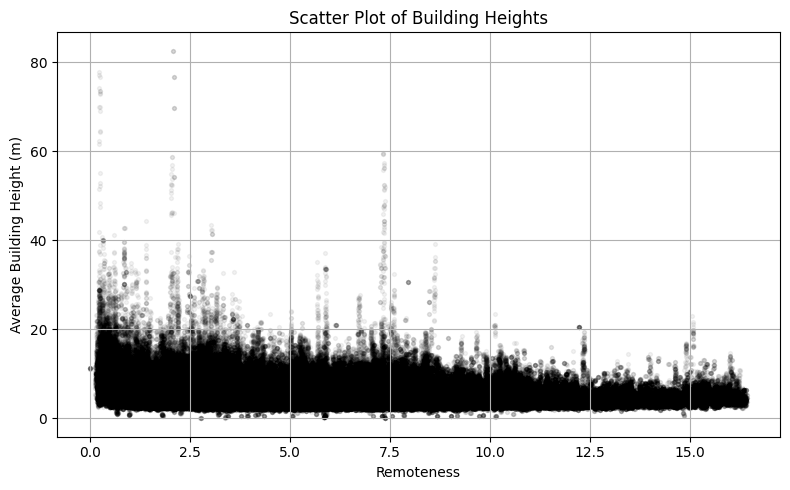

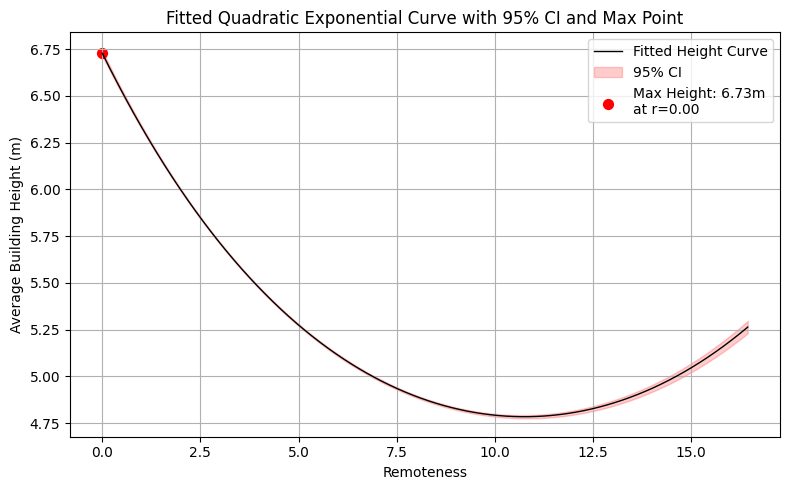

In [54]:
sample_and_fit_height_model(df_16, random_state=72)

样本量: 1323235
Fitted parameters:
  alpha = 17.9744 (95% CI: 17.8953, 18.0534)
  beta  = 0.1924 (95% CI: 0.1884, 0.1964)
  gamma = 0.0239 (95% CI: 0.0231, 0.0246)


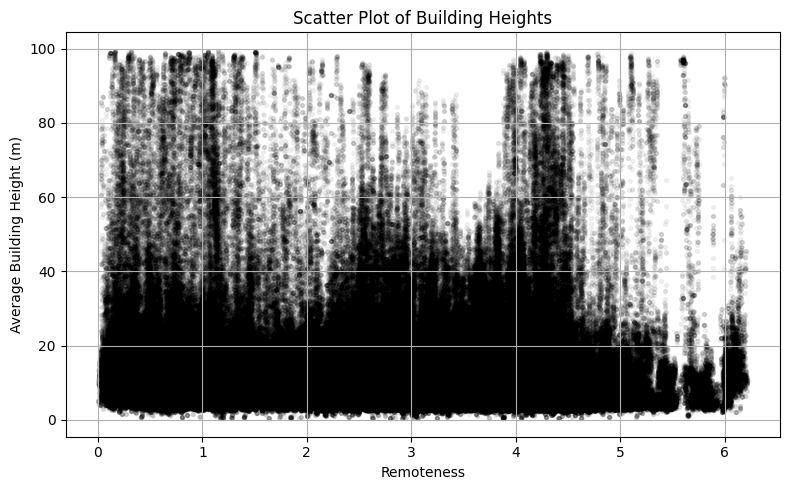

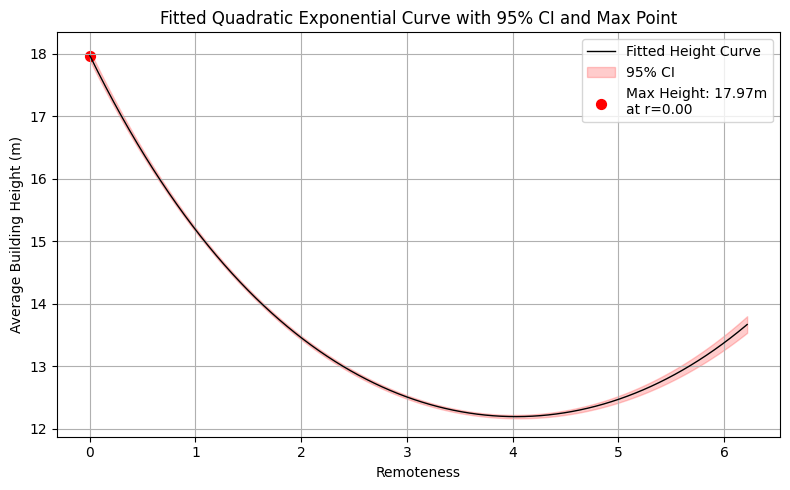

In [55]:
sample_and_fit_height_model(df_16_mumbai, random_state=72)

样本量: 8380218
Fitted parameters:
  alpha = 9.6875 (95% CI: 9.6683, 9.7067)
  beta  = 0.1837 (95% CI: 0.1821, 0.1853)
  gamma = 0.0134 (95% CI: 0.0131, 0.0137)


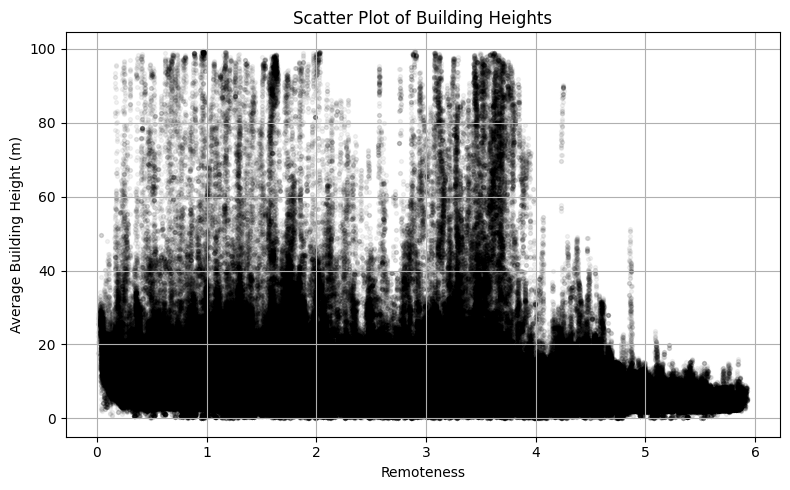

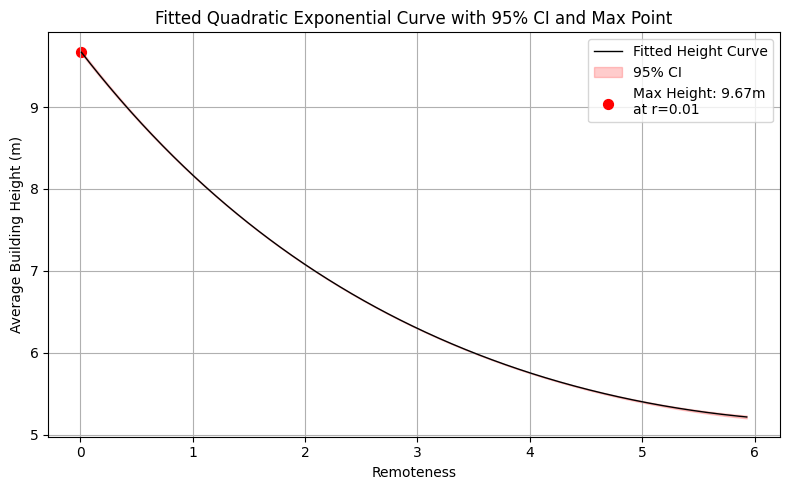

In [56]:
sample_and_fit_height_model(df_16_mexico,random_state=72)

## 批量拟合

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 定义二次指数函数
def height_model(remoteness, alpha, beta, gamma):
    return alpha * np.exp(-beta * remoteness + gamma * remoteness**2)

def fit_height_model_for_city(df):
    """对单个城市的数据进行拟合"""
    # 筛选有效数据
    df_nz = df[(df['avg_height'] > 0) & (df['building_count'] > 0)]
    
    if len(df_nz) < 10:  # 如果数据量太少，跳过
        return None
    
    xdata = df_nz['remoteness'].values
    ydata = df_nz['avg_height'].values
    
    # 初始参数
    p0 = [10, 0.1, 0.01]
    
    try:
        params, covariance = curve_fit(
            height_model, xdata, ydata, p0=p0, maxfev=20000
        )
        alpha, beta, gamma = params
        
        # 计算置信区间
        se = np.sqrt(np.diag(covariance))
        ci_lower = params - 1.96 * se
        ci_upper = params + 1.96 * se
        
        return {
            'alpha': alpha,
            'beta': beta,
            'gamma': gamma,
            'alpha_ci_lower': ci_lower[0],
            'alpha_ci_upper': ci_upper[0],
            'beta_ci_lower': ci_lower[1],
            'beta_ci_upper': ci_upper[1],
            'gamma_ci_lower': ci_lower[2],
            'gamma_ci_upper': ci_upper[2],
            'sample_size': len(df_nz)
        }
    except Exception as e:
        print(f"    拟合失败: {str(e)}")
        return None

# 读取城市列表
cities = pd.read_csv("CitiesDB_new.csv")

# 准备结果列表
results = []

# 遍历每个城市和年份
years = [2016, 2023]

print("开始批量拟合height模型...")
print(f"总共需要处理: {len(cities)} 个城市 × {len(years)} 年 = {len(cities) * len(years)} 个数据集\n")

# 使用tqdm创建进度条
for idx, row in tqdm(cities.iterrows(), total=len(cities), desc="处理城市"):
    city_name = row['Name']
    
    for year in years:
        try:
            # 构建文件路径
            file_path = f"aggregated_data/{city_name}_{year}_3x3_windows.csv"
            
            # 读取数据
            df = pd.read_csv(file_path)
            
            # 获取人口数据
            pop_col = f'pop_{year}_UN'
            if pop_col not in cities.columns:
                print(f"  ⚠️  {city_name} {year}: 缺少人口数据列 {pop_col}")
                continue
                
            pop = row[pop_col] * 1000
            
            # 计算remoteness
            df['remoteness'] = (df['distance_to_center'] / np.sqrt(pop)) * 1000
            df['bd'] = 9
            
            # 进行拟合
            fit_result = fit_height_model_for_city(df)
            
            if fit_result is not None:
                # 添加城市和年份信息
                fit_result['city'] = city_name
                fit_result['year'] = year
                fit_result['population'] = pop
                results.append(fit_result)
                print(f"  ✓ {city_name} {year} 完成 (样本量: {fit_result['sample_size']})")
            else:
                print(f"  ✗ {city_name} {year} 拟合失败")
                
        except FileNotFoundError:
            print(f"  ⚠️  {city_name} {year}: 文件不存在")
        except Exception as e:
            print(f"  ✗ {city_name} {year}: 发生错误 - {str(e)}")

# 转换为DataFrame并保存
results_df = pd.DataFrame(results)

# 重新排列列的顺序
column_order = [
    'city', 'year', 'population', 'sample_size',
    'alpha', 'alpha_ci_lower', 'alpha_ci_upper',
    'beta', 'beta_ci_lower', 'beta_ci_upper',
    'gamma', 'gamma_ci_lower', 'gamma_ci_upper'
]
results_df = results_df[column_order]

# 保存结果
results_df.to_csv('height_fitting_results.csv', index=False)

print("\n" + "="*60)
print("批量拟合完成！")
print(f"成功拟合: {len(results_df)} 个数据集")
print(f"结果已保存到: height_fitting_results.csv")
print("="*60)

# 显示前几行结果
print("\n结果预览:")
print(results_df.head(10))

开始批量拟合height模型...
总共需要处理: 104 个城市 × 2 年 = 208 个数据集



处理城市:   0%|                                         | 0/104 [00:00<?, ?it/s]

  ✓ Antananarivo 2016 完成 (样本量: 1157558)


处理城市:   1%|▎                                | 1/104 [00:10<17:42, 10.32s/it]

  ✓ Antananarivo 2023 完成 (样本量: 1388524)
  ✓ Abidjan 2016 完成 (样本量: 2230953)


处理城市:   2%|▋                                | 2/104 [00:21<18:25, 10.84s/it]

  ✓ Abidjan 2023 完成 (样本量: 2926070)
  ✓ Yaounde 2016 完成 (样本量: 1688897)


处理城市:   3%|▉                                | 3/104 [00:33<19:09, 11.38s/it]

  ✓ Yaounde 2023 完成 (样本量: 2189998)
  ✓ Lusaka 2016 完成 (样本量: 1996955)


处理城市:   4%|█▎                               | 4/104 [00:44<18:50, 11.31s/it]

  ✓ Lusaka 2023 完成 (样本量: 2694822)
  ✓ Hanoi 2016 完成 (样本量: 3962536)


处理城市:   5%|█▌                               | 5/104 [00:57<19:26, 11.78s/it]

  ✓ Hanoi 2023 完成 (样本量: 4573868)
  ✓ Monterrey 2016 完成 (样本量: 4152160)


处理城市:   6%|█▉                               | 6/104 [01:10<20:09, 12.34s/it]

  ✓ Monterrey 2023 完成 (样本量: 4520128)
  ✓ Buenos Aires 2016 完成 (样本量: 6474926)


处理城市:   7%|██▏                              | 7/104 [01:28<22:50, 14.13s/it]

  ✓ Buenos Aires 2023 完成 (样本量: 6570975)
  ✓ Medan 2016 完成 (样本量: 3562883)


处理城市:   8%|██▌                              | 8/104 [01:41<22:03, 13.78s/it]

  ✓ Medan 2023 完成 (样本量: 3951887)
  ✓ Cairo 2016 完成 (样本量: 5003108)


处理城市:   9%|██▊                              | 9/104 [01:55<22:01, 13.91s/it]

  ✓ Cairo 2023 完成 (样本量: 5304380)
  ✓ Lagos 2016 完成 (样本量: 4349435)


处理城市:  10%|███                             | 10/104 [02:09<21:30, 13.73s/it]

  ✓ Lagos 2023 完成 (样本量: 4860304)
  ✓ Onitsha 2016 完成 (样本量: 2144884)


处理城市:  11%|███▍                            | 11/104 [02:21<20:32, 13.25s/it]

  ✓ Onitsha 2023 完成 (样本量: 2647491)
  ✓ Johannesburg 2016 完成 (样本量: 5896597)


处理城市:  12%|███▋                            | 12/104 [02:38<22:13, 14.49s/it]

  ✓ Johannesburg 2023 完成 (样本量: 6205373)
  ✓ Kinshasa 2016 完成 (样本量: 2776264)


处理城市:  12%|████                            | 13/104 [02:51<21:10, 13.96s/it]

  ✓ Kinshasa 2023 完成 (样本量: 2732789)
  ✓ Luanda 2016 完成 (样本量: 3113025)


处理城市:  13%|████▎                           | 14/104 [03:04<20:25, 13.62s/it]

  ✓ Luanda 2023 完成 (样本量: 2551240)
  ✓ Alexandria 2016 完成 (样本量: 1561332)


处理城市:  14%|████▌                           | 15/104 [03:15<19:09, 12.92s/it]

  ✓ Alexandria 2023 完成 (样本量: 1630860)
  ✓ Nairobi 2016 完成 (样本量: 2901339)


处理城市:  15%|████▉                           | 16/104 [03:28<18:52, 12.87s/it]

  ✓ Nairobi 2023 完成 (样本量: 3418637)
  ✓ Dar es Salaam 2016 完成 (样本量: 3100812)


处理城市:  16%|█████▏                          | 17/104 [03:41<19:00, 13.11s/it]

  ✓ Dar es Salaam 2023 完成 (样本量: 3862885)
  ✓ Kisumu 2016 完成 (样本量: 871146)


处理城市:  17%|█████▌                          | 18/104 [03:54<18:37, 13.00s/it]

  ✓ Kisumu 2023 完成 (样本量: 1058283)
  ✓ Accra 2016 完成 (样本量: 3746231)


处理城市:  18%|█████▊                          | 19/104 [04:09<19:13, 13.57s/it]

  ✓ Accra 2023 完成 (样本量: 4444852)
  ✓ Kano 2016 完成 (样本量: 1958132)


处理城市:  19%|██████▏                         | 20/104 [04:22<18:38, 13.31s/it]

  ✓ Kano 2023 完成 (样本量: 2457795)
  ✓ Algiers 2016 完成 (样本量: 2165318)


处理城市:  20%|██████▍                         | 21/104 [04:34<18:02, 13.04s/it]

  ✓ Algiers 2023 完成 (样本量: 2321501)
  ✓ Kampala 2016 完成 (样本量: 3197576)


处理城市:  21%|██████▊                         | 22/104 [04:48<18:08, 13.28s/it]

  ✓ Kampala 2023 完成 (样本量: 4132295)
  ✓ Addis Ababa 2016 完成 (样本量: 2482888)


处理城市:  22%|███████                         | 23/104 [05:01<17:43, 13.13s/it]

  ✓ Addis Ababa 2023 完成 (样本量: 3129105)
  ✓ Cape Town 2016 完成 (样本量: 2476531)


处理城市:  23%|███████▍                        | 24/104 [05:14<17:35, 13.20s/it]

  ✓ Cape Town 2023 完成 (样本量: 2570849)
  ✓ Ibadan 2016 完成 (样本量: 3316328)


处理城市:  24%|███████▋                        | 25/104 [05:28<17:39, 13.41s/it]

  ✓ Ibadan 2023 完成 (样本量: 4076395)
  ✓ Dakar 2016 完成 (样本量: 1248723)


处理城市:  25%|████████                        | 26/104 [05:40<16:41, 12.84s/it]

  ✓ Dakar 2023 完成 (样本量: 1407234)
  ✓ Kumasi 2016 完成 (样本量: 2687765)


处理城市:  26%|████████▎                       | 27/104 [05:53<16:35, 12.93s/it]

  ✓ Kumasi 2023 完成 (样本量: 3567064)
  ✓ Maputo 2016 完成 (样本量: 1929678)


处理城市:  27%|████████▌                       | 28/104 [06:06<16:23, 12.95s/it]

  ✓ Maputo 2023 完成 (样本量: 2392774)
  ✓ Ouagadougou 2016 完成 (样本量: 1467080)


处理城市:  28%|████████▉                       | 29/104 [06:17<15:25, 12.34s/it]

  ✓ Ouagadougou 2023 完成 (样本量: 2434164)
  ✓ Harare 2016 完成 (样本量: 1958618)


处理城市:  29%|█████████▏                      | 30/104 [06:28<14:46, 11.98s/it]

  ✓ Harare 2023 完成 (样本量: 2430801)
  ✓ Kigali 2016 完成 (样本量: 1403581)


处理城市:  30%|█████████▌                      | 31/104 [06:39<14:09, 11.63s/it]

  ✓ Kigali 2023 完成 (样本量: 1870201)
  ✓ Conakry 2016 完成 (样本量: 975235)


处理城市:  31%|█████████▊                      | 32/104 [06:50<13:57, 11.63s/it]

  ✓ Conakry 2023 完成 (样本量: 1060641)
  ✓ Abuja 2016 完成 (样本量: 2146400)


处理城市:  32%|██████████▏                     | 33/104 [07:02<13:58, 11.82s/it]

  ✓ Abuja 2023 完成 (样本量: 2696915)
  ✓ Aba 2016 完成 (样本量: 1477412)


处理城市:  33%|██████████▍                     | 34/104 [07:15<13:55, 11.93s/it]

  ✓ Aba 2023 完成 (样本量: 1541469)
  ✓ Brazzaville 2016 完成 (样本量: 2657547)


处理城市:  34%|██████████▊                     | 35/104 [07:28<14:13, 12.37s/it]

  ✓ Brazzaville 2023 完成 (样本量: 2581630)
  ✓ Freetown 2016 完成 (样本量: 749099)


处理城市:  35%|███████████                     | 36/104 [07:39<13:34, 11.97s/it]

  ✓ Freetown 2023 完成 (样本量: 931275)
  ✓ Mombasa 2016 完成 (样本量: 909394)


处理城市:  36%|███████████▍                    | 37/104 [07:50<13:02, 11.68s/it]

  ✓ Mombasa 2023 完成 (样本量: 1130580)
  ✓ Monrovia 2016 完成 (样本量: 999136)


处理城市:  37%|███████████▋                    | 38/104 [08:02<12:50, 11.68s/it]

  ✓ Monrovia 2023 完成 (样本量: 1367699)
  ✓ Lilongwe 2016 完成 (样本量: 827813)


处理城市:  38%|████████████                    | 39/104 [08:16<13:21, 12.34s/it]

  ✓ Lilongwe 2023 完成 (样本量: 1103814)
  ✓ Niamey 2016 完成 (样本量: 743044)


处理城市:  38%|████████████▎                   | 40/104 [08:27<12:57, 12.14s/it]

  ✓ Niamey 2023 完成 (样本量: 1084605)
  ✓ Nouakchott 2016 完成 (样本量: 784547)


处理城市:  39%|████████████▌                   | 41/104 [08:39<12:42, 12.10s/it]

  ✓ Nouakchott 2023 完成 (样本量: 1066520)
  ✓ Bujumbura 2016 完成 (样本量: 754113)


处理城市:  40%|████████████▉                   | 42/104 [08:51<12:21, 11.95s/it]

  ✓ Bujumbura 2023 完成 (样本量: 949154)
  ✓ Oran 2016 完成 (样本量: 1001390)


处理城市:  41%|█████████████▏                  | 43/104 [09:03<12:06, 11.91s/it]

  ✓ Oran 2023 完成 (样本量: 1091722)
  ✓ Bangui 2016 完成 (样本量: 484607)


处理城市:  42%|█████████████▌                  | 44/104 [09:15<11:52, 11.88s/it]

  ✓ Bangui 2023 完成 (样本量: 676214)
  ✓ Libreville 2016 完成 (样本量: 944648)


处理城市:  43%|█████████████▊                  | 45/104 [09:26<11:36, 11.81s/it]

  ✓ Libreville 2023 完成 (样本量: 1133248)
  ✓ Constantine 2016 完成 (样本量: 823098)


处理城市:  44%|██████████████▏                 | 46/104 [09:38<11:26, 11.84s/it]

  ✓ Constantine 2023 完成 (样本量: 918130)
  ✓ Bobo-Dioulasso 2016 完成 (样本量: 522601)


处理城市:  45%|██████████████▍                 | 47/104 [09:50<11:12, 11.80s/it]

  ✓ Bobo-Dioulasso 2023 完成 (样本量: 783362)
  ✓ Windhoek 2016 完成 (样本量: 517157)


处理城市:  46%|██████████████▊                 | 48/104 [10:02<11:07, 11.93s/it]

  ✓ Windhoek 2023 完成 (样本量: 582577)
  ✓ Jakarta 2016 完成 (样本量: 7657964)


处理城市:  47%|███████████████                 | 49/104 [10:18<12:06, 13.22s/it]

  ✓ Jakarta 2023 完成 (样本量: 8055817)
  ✓ Delhi 2016 完成 (样本量: 5749026)


处理城市:  48%|███████████████▍                | 50/104 [10:32<12:06, 13.46s/it]

  ✓ Delhi 2023 完成 (样本量: 6027087)
  ✓ Mumbai 2016 完成 (样本量: 1323235)


处理城市:  49%|███████████████▋                | 51/104 [10:44<11:21, 12.86s/it]

  ✓ Mumbai 2023 完成 (样本量: 1260869)
  ✓ Manila 2016 完成 (样本量: 5024162)


处理城市:  50%|████████████████                | 52/104 [10:59<11:43, 13.53s/it]

  ✓ Manila 2023 完成 (样本量: 5271012)
  ✓ Dhaka 2016 完成 (样本量: 3006813)


处理城市:  51%|████████████████▎               | 53/104 [11:12<11:21, 13.36s/it]

  ✓ Dhaka 2023 完成 (样本量: 3518443)
  ✓ Kolkata 2016 完成 (样本量: 5244192)


处理城市:  52%|████████████████▌               | 54/104 [11:27<11:31, 13.83s/it]

  ✓ Kolkata 2023 完成 (样本量: 5358912)
  ✓ Bangkok 2016 完成 (样本量: 8348732)


处理城市:  53%|████████████████▉               | 55/104 [11:44<12:08, 14.87s/it]

  ✓ Bangkok 2023 完成 (样本量: 9057031)
  ✓ Karachi 2016 完成 (样本量: 3436368)


处理城市:  54%|█████████████████▏              | 56/104 [11:57<11:28, 14.35s/it]

  ✓ Karachi 2023 完成 (样本量: 3630105)
  ✓ Bangalore 2016 完成 (样本量: 4529948)


处理城市:  55%|█████████████████▌              | 57/104 [12:12<11:19, 14.46s/it]

  ✓ Bangalore 2023 完成 (样本量: 5171746)
  ✓ Ho Chi Minh City 2016 完成 (样本量: 5280143)


处理城市:  56%|█████████████████▊              | 58/104 [12:27<11:18, 14.75s/it]

  ✓ Ho Chi Minh City 2023 完成 (样本量: 5995475)
  ✓ Chennai 2016 完成 (样本量: 3446918)


处理城市:  57%|██████████████████▏             | 59/104 [12:40<10:42, 14.28s/it]

  ✓ Chennai 2023 完成 (样本量: 3684603)
  ✓ Hyderabad 2016 完成 (样本量: 4357118)


处理城市:  58%|██████████████████▍             | 60/104 [12:55<10:29, 14.30s/it]

  ✓ Hyderabad 2023 完成 (样本量: 5097792)
  ✓ Kuala Lumpur 2016 完成 (样本量: 4348867)


处理城市:  59%|██████████████████▊             | 61/104 [13:10<10:26, 14.56s/it]

  ✓ Kuala Lumpur 2023 完成 (样本量: 4638961)
  ✓ Bandung 2016 完成 (样本量: 4161878)


处理城市:  60%|███████████████████             | 62/104 [13:25<10:16, 14.68s/it]

  ✓ Bandung 2023 完成 (样本量: 4512840)
  ✓ Pune 2016 完成 (样本量: 2653218)


处理城市:  61%|███████████████████▍            | 63/104 [13:38<09:45, 14.28s/it]

  ✓ Pune 2023 完成 (样本量: 3130447)
  ✓ Ahmedabad 2016 完成 (样本量: 2684685)


处理城市:  62%|███████████████████▋            | 64/104 [13:51<09:10, 13.76s/it]

  ✓ Ahmedabad 2023 完成 (样本量: 3065199)
  ✓ Surat 2016 完成 (样本量: 1760361)


处理城市:  62%|████████████████████            | 65/104 [14:03<08:38, 13.30s/it]

  ✓ Surat 2023 完成 (样本量: 2018816)
  ✓ Surabaya 2016 完成 (样本量: 3687096)


处理城市:  63%|████████████████████▎           | 66/104 [14:17<08:37, 13.61s/it]

  ✓ Surabaya 2023 完成 (样本量: 4024617)
  ✓ Jaipur 2016 完成 (样本量: 2743127)


处理城市:  64%|████████████████████▌           | 67/104 [14:30<08:16, 13.43s/it]

  ✓ Jaipur 2023 完成 (样本量: 3270490)
  ✓ Phnom Penh 2016 完成 (样本量: 1934730)


处理城市:  65%|████████████████████▉           | 68/104 [14:44<08:00, 13.35s/it]

  ✓ Phnom Penh 2023 完成 (样本量: 2817230)
  ✓ Denpasar 2016 完成 (样本量: 2722055)


处理城市:  66%|█████████████████████▏          | 69/104 [14:58<08:01, 13.75s/it]

  ✓ Denpasar 2023 完成 (样本量: 3046745)
  ✓ Davao 2016 完成 (样本量: 1005712)


处理城市:  67%|█████████████████████▌          | 70/104 [15:10<07:29, 13.22s/it]

  ✓ Davao 2023 完成 (样本量: 1304968)
  ✓ Semarang 2016 完成 (样本量: 2503763)


处理城市:  68%|█████████████████████▊          | 71/104 [15:24<07:22, 13.42s/it]

  ✓ Semarang 2023 完成 (样本量: 2801679)
  ✓ Palembang 2016 完成 (样本量: 1670961)


处理城市:  69%|██████████████████████▏         | 72/104 [15:37<07:03, 13.23s/it]

  ✓ Palembang 2023 完成 (样本量: 1941851)
  ✓ Makassar 2016 完成 (样本量: 1591431)


处理城市:  70%|██████████████████████▍         | 73/104 [15:49<06:43, 13.02s/it]

  ✓ Makassar 2023 完成 (样本量: 1857910)
  ✓ Batam 2016 完成 (样本量: 1192020)


处理城市:  71%|██████████████████████▊         | 74/104 [16:02<06:23, 12.78s/it]

  ✓ Batam 2023 完成 (样本量: 1341989)
  ✓ Bandar Lampung 2016 完成 (样本量: 1636852)


处理城市:  72%|███████████████████████         | 75/104 [16:14<06:10, 12.77s/it]

  ✓ Bandar Lampung 2023 完成 (样本量: 1919586)
  ✓ Kathmandu 2016 完成 (样本量: 1731642)


处理城市:  73%|███████████████████████▍        | 76/104 [16:27<05:54, 12.65s/it]

  ✓ Kathmandu 2023 完成 (样本量: 2275523)
  ✓ Sao Paulo 2016 完成 (样本量: 8884227)


处理城市:  74%|███████████████████████▋        | 77/104 [16:46<06:35, 14.65s/it]

  ✓ Sao Paulo 2023 完成 (样本量: 9067164)
  ✓ Mexico City 2016 完成 (样本量: 8380218)


处理城市:  75%|████████████████████████        | 78/104 [17:04<06:47, 15.68s/it]

  ✓ Mexico City 2023 完成 (样本量: 8597739)
  ✓ Rio de Janeiro 2016 完成 (样本量: 3537181)


处理城市:  76%|████████████████████████▎       | 79/104 [17:19<06:24, 15.39s/it]

  ✓ Rio de Janeiro 2023 完成 (样本量: 3604537)
  ✓ Lima 2016 完成 (样本量: 4059883)


处理城市:  77%|████████████████████████▌       | 80/104 [17:33<05:58, 14.93s/it]

  ✓ Lima 2023 完成 (样本量: 3756851)
  ✓ Bogota 2016 完成 (样本量: 2944665)


处理城市:  78%|████████████████████████▉       | 81/104 [17:46<05:29, 14.31s/it]

  ✓ Bogota 2023 完成 (样本量: 3087787)
  ✓ Guadalajara 2016 完成 (样本量: 4245167)


处理城市:  79%|█████████████████████████▏      | 82/104 [18:00<05:17, 14.41s/it]

  ✓ Guadalajara 2023 完成 (样本量: 4558785)
  ✓ Belo Horizonte 2016 完成 (样本量: 3995847)


处理城市:  80%|█████████████████████████▌      | 83/104 [18:15<05:07, 14.63s/it]

  ✓ Belo Horizonte 2023 完成 (样本量: 4231898)
  ✓ Brasilia 2016 完成 (样本量: 1913906)


处理城市:  81%|█████████████████████████▊      | 84/104 [18:29<04:45, 14.30s/it]

  ✓ Brasilia 2023 完成 (样本量: 2130060)
  ✓ Guatemala City 2016 完成 (样本量: 2540295)


处理城市:  82%|██████████████████████████▏     | 85/104 [18:42<04:26, 14.04s/it]

  ✓ Guatemala City 2023 完成 (样本量: 2866387)
  ✓ Salvador 2016 完成 (样本量: 1552945)


处理城市:  83%|██████████████████████████▍     | 86/104 [18:54<04:01, 13.42s/it]

  ✓ Salvador 2023 完成 (样本量: 1655546)
  ✓ La Paz 2016 完成 (样本量: 1625706)


处理城市:  84%|██████████████████████████▊     | 87/104 [19:07<03:42, 13.07s/it]

  ✓ La Paz 2023 完成 (样本量: 1965985)
  ✓ Guayaquil 2016 完成 (样本量: 1788128)


处理城市:  85%|███████████████████████████     | 88/104 [19:19<03:24, 12.78s/it]

  ✓ Guayaquil 2023 完成 (样本量: 2011303)
  ✓ Santo Domingo 2016 完成 (样本量: 2037540)


处理城市:  86%|███████████████████████████▍    | 89/104 [19:32<03:12, 12.81s/it]

  ✓ Santo Domingo 2023 完成 (样本量: 2311861)
  ✓ Medellin 2016 完成 (样本量: 1890194)


处理城市:  87%|███████████████████████████▋    | 90/104 [19:45<03:00, 12.89s/it]

  ✓ Medellin 2023 完成 (样本量: 2088081)
  ✓ Cali 2016 完成 (样本量: 1344659)


处理城市:  88%|████████████████████████████    | 91/104 [19:57<02:46, 12.80s/it]

  ✓ Cali 2023 完成 (样本量: 1514631)
  ✓ Quito 2016 完成 (样本量: 2422568)


处理城市:  88%|████████████████████████████▎   | 92/104 [20:12<02:38, 13.23s/it]

  ✓ Quito 2023 完成 (样本量: 2690586)
  ✓ Tegucigalpa 2016 完成 (样本量: 919946)


处理城市:  89%|████████████████████████████▌   | 93/104 [20:24<02:23, 13.00s/it]

  ✓ Tegucigalpa 2023 完成 (样本量: 1096652)
  ✓ Leon 2016 完成 (样本量: 1724944)


处理城市:  90%|████████████████████████████▉   | 94/104 [20:37<02:09, 12.95s/it]

  ✓ Leon 2023 完成 (样本量: 1976297)
  ✓ Puebla 2016 完成 (样本量: 2867702)


处理城市:  91%|█████████████████████████████▏  | 95/104 [20:51<01:59, 13.32s/it]

  ✓ Puebla 2023 完成 (样本量: 3145680)
  ✓ San Jose 2016 完成 (样本量: 2786067)


处理城市:  92%|█████████████████████████████▌  | 96/104 [21:05<01:47, 13.47s/it]

  ✓ San Jose 2023 完成 (样本量: 3046057)
  ✓ Managua 2016 完成 (样本量: 1260329)


处理城市:  93%|█████████████████████████████▊  | 97/104 [21:17<01:32, 13.18s/it]

  ✓ Managua 2023 完成 (样本量: 1375286)
  ✓ Port-au-Prince 2016 完成 (样本量: 1479292)


处理城市:  94%|██████████████████████████████▏ | 98/104 [21:30<01:18, 13.05s/it]

  ✓ Port-au-Prince 2023 完成 (样本量: 1718792)
  ✓ Merida 2016 完成 (样本量: 1852617)


处理城市:  95%|██████████████████████████████▍ | 99/104 [21:44<01:07, 13.41s/it]

  ✓ Merida 2023 完成 (样本量: 2114587)
  ✓ Cancun 2016 完成 (样本量: 719118)


处理城市:  96%|█████████████████████████████▊ | 100/104 [21:56<00:51, 12.99s/it]

  ✓ Cancun 2023 完成 (样本量: 851303)
  ✓ Queretaro 2016 完成 (样本量: 1735467)


处理城市:  97%|██████████████████████████████ | 101/104 [22:09<00:38, 12.97s/it]

  ✓ Queretaro 2023 完成 (样本量: 2119481)
  ✓ Acapulco 2016 完成 (样本量: 774843)


处理城市:  98%|██████████████████████████████▍| 102/104 [22:21<00:25, 12.73s/it]

  ✓ Acapulco 2023 完成 (样本量: 830556)
  ✓ San Salvador 2016 完成 (样本量: 1692485)


处理城市:  99%|██████████████████████████████▋| 103/104 [22:35<00:12, 12.85s/it]

  ✓ San Salvador 2023 完成 (样本量: 1906563)
  ✓ Asuncion 2016 完成 (样本量: 2579468)


处理城市: 100%|███████████████████████████████| 104/104 [22:48<00:00, 13.16s/it]

  ✓ Asuncion 2023 完成 (样本量: 2958174)

批量拟合完成！
成功拟合: 208 个数据集
结果已保存到: height_fitting_results.csv

结果预览:
           city  year  population  sample_size      alpha  alpha_ci_lower  \
0  Antananarivo  2016   2757316.0      1157558   6.729840        6.716246   
1  Antananarivo  2023   3872264.0      1388524   7.150413        7.135700   
2       Abidjan  2016   4658790.0      2230953   6.373408        6.356882   
3       Abidjan  2023   5686350.0      2926070   6.681455        6.665887   
4       Yaounde  2016   3272870.0      1688897   6.253017        6.243561   
5       Yaounde  2023   4509287.0      2189998   6.149781        6.140468   
6        Lusaka  2016   2294091.0      1996955   5.300918        5.289125   
7        Lusaka  2023   3181250.0      2694822   5.624860        5.613207   
8         Hanoi  2016   3854847.0      3962536  15.949064       15.908620   
9         Hanoi  2023   5253385.0      4573868  16.986804       16.942507   

   alpha_ci_upper      beta  beta_ci_lower  beta_c

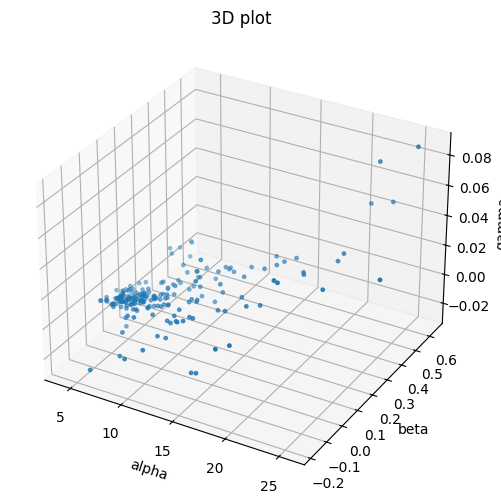

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# 假设数据如下
# 城市,参数A,参数B,参数C
df = pd.read_csv("height_fitting_results.csv")

# 创建3D坐标轴
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

# 绘制散点
sc = ax.scatter(
    df["alpha"], 
    df["beta"], 
    df["gamma"],
    s=6
)

# 添加坐标轴标签
ax.set_xlabel("alpha")
ax.set_ylabel("beta")
ax.set_zlabel("gamma")
ax.set_title("3D plot")

# 可选：添加颜色条
#plt.colorbar(sc, ax=ax, label="参数A 值")

plt.show()